Connected to pytorch_env (Python 3.10.16)

In [ ]:
########################################################################################################################
####-------| NOTE 1.A. IMPORTS LIBRARIES | XXX -----------------------------------------------------####################
########################################################################################################################


"""Train CIFAR100 with PyTorch."""

# Python 2/3 compatibility
# from __future__ import print_function


# Standard libraries
import sys
import os
import argparse
from tqdm import tqdm
import math
import random
import numpy as np


# PyTorch and related modules
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

# torchvision for datasets and transforms
import torchvision
import torchvision.transforms as transforms
import torch_optimizer as torch_opt  # Use 'torch_opt' for torch_optimizer
from timm.scheduler import CosineLRScheduler 
from torch.optim.lr_scheduler import OneCycleLR





# ✅ Define currect working directory to ensure on right directory
VGG16_PATH = r"C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated"
if os.getcwd() != VGG16_PATH:
    os.chdir(VGG16_PATH)
print(f"✅ Current working directory: {os.getcwd()}")

# ✅ Define absolute paths
PROJECT_PATH = VGG16_PATH
MODELS_PATH = os.path.join(VGG16_PATH, "models")
ACTIVATION_PATH = os.path.join(VGG16_PATH, "activation")
# PAU_PATH = os.path.join(VGG16_PATH, "pau")

# ✅ Ensure necessary paths are in sys.path
for path in [PROJECT_PATH, MODELS_PATH, ACTIVATION_PATH]:
    if path not in sys.path:
        sys.path.append(path)

# ✅ Print updated sys.path for debugging
print("✅ sys.path updated:")
for path in sys.path:
    print("   📂", path)

# ✅ Import FFTGate (Check if the module exists)
try:
    from activation.FFTGate import FFTGate  # type: ignore
    print("✅ FFTGate imported successfully!")
except ModuleNotFoundError as e:
    print(f"❌ Import failed: {e}")
    print(f"🔍 Check that 'Activation4.py' exists inside: {ACTIVATION_PATH}")

# ✅ Test if FFTGate is callable
try:
    activation_test = FFTGate()
    print("✅ FFTGate instance created successfully!")
except Exception as e:
    print(f"❌ Error while initializing FFTGate: {e}")

# ✅ Now import FFTGate_VGG (Ensure module exists inside models/)
try:
    from models.FFTGate_VGG import FFTGate_VGG  # type: ignore
    print("✅ FFTGate_VGG imported successfully!")
except ModuleNotFoundError as e:
    print(f"❌ FFTGate_VGG import failed: {e}")
    print(f"🔍 Check that 'FFTGate_VGG.py' exists inside: {MODELS_PATH}")






########################################################################################################################
####-------| NOTE 1.B. SEEDING FOR REPRODUCIBILITY | XXX -------------------------------------------####################
########################################################################################################################

def set_seed_torch(seed):
    torch.manual_seed(seed)                          



def set_seed_main(seed):
    random.seed(seed)                                ## Python's random module
    np.random.seed(seed)                             ## NumPy's random module
    torch.cuda.manual_seed(seed)                     ## PyTorch's random module for CUDA
    torch.cuda.manual_seed_all(seed)                 ## Seed for all CUDA devices
    torch.backends.cudnn.deterministic = True        ## Ensure deterministic behavior for CuDNN
    torch.backends.cudnn.benchmark = False           ## Disable CuDNN's autotuning for reproducibility



# Variable seed for DataLoader shuffling
set_seed_torch(1)   

# Variable main seed (model, CUDA, etc.)
set_seed_main(2)  







# (Optional) Import Optimizers - Uncomment as needed
# from Opt import opt
# from diffGrad import diffGrad
# from diffRGrad import diffRGrad, SdiffRGrad, BetaDiffRGrad, Beta12DiffRGrad, BetaDFCDiffRGrad
# from RADAM import Radam, BetaRadam
# from BetaAdam import BetaAdam, BetaAdam1, BetaAdam2, BetaAdam3, BetaAdam4, BetaAdam5, BetaAdam6, BetaAdam7, BetaAdam4A
# from AdamRM import AdamRM, AdamRM1, AdamRM2, AdamRM3, AdamRM4, AdamRM5
# from sadam import sadam
# from SdiffGrad import SdiffGrad
# from SRADAM import SRADAM








########################################################################################################################
####-------| NOTE 2. DEFINE MODEL Lr | XXX ---------------------------------------------------------####################
########################################################################################################################

# Main Execution (Placeholder)
if __name__ == "__main__":
    print("CIFAR100 Training Script Initialized...")
    # Add your training pipeline here


import argparse
import os

# Argument parser to get user inputs
parser = argparse.ArgumentParser(description='PyTorch CIFAR100 Training')
parser.add_argument('--lr', default=0.001, type=float, help='learning rate')
parser.add_argument('--resume', '-r', action='store_true', help='resume from checkpoint')

args, unknown = parser.parse_known_args()  # Avoids Jupyter argument issues
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Ensure lr is correctly parsed
lr = args.lr  # Get learning rate from argparse
lr_str = str(lr).replace('.', '_')  # Convert to string and replace '.' for filenames

# Debugging prints
print(f"Using device: {device}")
print(f"Parsed learning rate: {lr} (type: {type(lr)})")
print(f"Formatted learning rate for filenames: {lr_str}")

# Initialize training variables
best_acc = 0  # Best test accuracy
start_epoch = 0  # Start from epoch 0 or last checkpoint epoch







########################################################################################################################
####-------| NOTE 3. LOAD DATASET | XXX ------------------------------------------------------------####################
########################################################################################################################

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

bs = 64 #set batch size
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=0)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=0)
#classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')





# ✅ Length of train and test datasets
len_train = len(trainset)
len_test = len(testset)
print(f"Length of training dataset: {len_train}")
print(f"Length of testing dataset: {len_test}")

# ✅ Print number of classes
num_classes_Print = len(trainset.classes)
print(f"Number of classes in CIFAR-100: {num_classes_Print}")







########################################################################################################################
####-------| NOTE 4. DYNAMIC REGULARIZATION| XXX ---------------------------------------------------####################
########################################################################################################################



def apply_dynamic_regularization(inputs, feature_activations, epoch,
                                  prev_params, layer_index_map, batch_idx):


    global activation_layers  # ✅ Reference already-collected layers

    # ✅ Print gamma1 stats early in training for monitoring
    if batch_idx == 0 and epoch <= 4:
        print(f"\n🚨 ENTERED apply_dynamic_regularization | Epoch={epoch} | Batch={batch_idx}", flush=True)

        # 🧠 Print gamma1 details
        all_layer_info = []
        for idx, layer in enumerate(activation_layers):
            param = getattr(layer, "gamma1")
            all_layer_info.append(f"Layer {idx}: ID={id(param)} | Mean={param.mean().item():.5f}")
        print("🧠 GAMMA1 INFO:", " | ".join(all_layer_info), flush=True)

    # ✅ Initialize gamma1 regularization accumulator
    gamma1_reg = 0.0

    # ✅ Compute batch std and define regularization strength
    batch_std = torch.std(inputs) + 1e-6
    regularization_strength = 0.05 if epoch < 40 else (0.01 if epoch < 60 else 0.005)

    # ✅ Track layers where noise is injected (informative)
    noisy_layers = []
    for idx, layer in enumerate(activation_layers):
        if idx not in layer_index_map:
            continue

        prev_layer_params = prev_params[layer_index_map[idx]]
        param_name = "gamma1"
        param = getattr(layer, param_name)
        prev_param = prev_layer_params[param_name]

        # ✅ Target based on input stats
        target = compute_target(param_name, batch_std)

        # ✅ Adaptive Target Regularization
        gamma1_reg += regularization_strength * (param - target).pow(2).mean() * 1.2

        # ✅ Adaptive Cohesion Regularization
        cohesion = (param - prev_param).pow(2)
        gamma1_reg += 0.005 * cohesion.mean()

        # ✅ Adaptive Noise Regularization
        epoch_AddNoise = 50
        if epoch > epoch_AddNoise:
            param_variation = torch.abs(param - prev_param).mean()
            if param_variation < 0.015:
                noise = (0.001 + 0.0004 * batch_std.item()) * torch.randn_like(param)
                penalty = (param - (prev_param + noise)).pow(2).sum()
                gamma1_reg += 0.00015 * penalty
                noisy_layers.append(f"{idx} (Δ={param_variation.item():.5f})") # Collect index and variation

    # ✅ Print noise injection summary
    if batch_idx == 0 and epoch <= (epoch_AddNoise + 4) and noisy_layers:
        print(f"🔥 Stable Noise Injected | Epoch {epoch} | Batch {batch_idx} | Layers: " + ", ".join(noisy_layers), flush=True)
    mags = feature_activations.abs().mean(dim=(0, 2, 3))
    m = mags / mags.sum()
    gamma1_reg += 0.005 * (-(m * torch.log(m + 1e-6)).sum())

    return gamma1_reg


def compute_target(param_name, batch_std):
    if param_name == "gamma1":
        return 2.0 + 0.2 * batch_std.item()  

    raise ValueError(f"Unknown param {param_name}")





########################################################################################################################
####-------| NOTE 5. INITIALIZE MODEL | XXX --------------------------------------------------------####################
########################################################################################################################

# Model
print('==> Building model..')
#net = Elliott_VGG('VGG16'); net1 = 'Elliott_VGG16'
#net = GELU_MobileNet(); net1 = 'GELU_MobileNet'
#net = GELU_SENet18(); net1 = 'GELU_SENet18'
#net = PDELU_ResNet50(); net1 = 'PDELU_ResNet50'
# net = Sigmoid_GoogLeNet(); net1 = 'Sigmoid_GoogLeNet'
#net = GELU_DenseNet121(); net1 = 'GELU_DenseNet121'
# net = ReLU_VGG('VGG16'); net1 = 'ReLU_VGG16'
net = FFTGate_VGG('VGG16'); net1 = 'FFTGate_VGG16'


net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=0.9); optimizer1 = 'SGDM5'
#optimizer = optim.Adagrad(net.parameters()); optimizer1 = 'AdaGrad'
#optimizer = optim.Adadelta(net.parameters()); optimizer1 = 'AdaDelta'
#optimizer = optim.RMSprop(net.parameters()); optimizer1 = 'RMSprop'
optimizer = optim.Adam(net.parameters(), lr=args.lr); optimizer1 = 'Adam'
#optimizer = optim.Adam(net.parameters(), lr=args.lr, amsgrad=True); optimizer1 = 'amsgrad'
#optimizer = diffGrad(net.parameters(), lr=args.lr); optimizer1 = 'diffGrad'
#optimizer = Radam(net.parameters(), lr=args.lr); optimizer1 = 'Radam'







########################################################################################################################
####-------| NOTE 6. INITIALIZE ACTIVATION PARAMETERS, OPTIMIZERS & SCHEDULERS | XXX ---------------####################
########################################################################################################################

import torch
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# ✅ Step 1: Collect Activation Parameters from ALL Layers (Ensure Compatibility with DataParallel)
if isinstance(net, torch.nn.DataParallel):
    features = net.module.features
else:
    features = net.features





# ✅ Step 2: Recursively search for FFTGate layers
activation_params = []
activation_layers = []

for layer in features:
    if isinstance(layer, FFTGate):  
        activation_layers.append(layer)
        activation_params.append(layer.gamma1)  # ✅ Only gamma1 is trainable





# ✅ Step 3: Define Unfreeze Epoch
unfreeze_activation_epoch = 1  # ✅ Change this value if needed
# unfreeze_activation_epoch = 10  # ✅ Delay unfreezing until epoch 10


# ✅ Define the warm-up epoch value
# WARMUP_ACTIVATION_EPOCHS = 5  # The number of epochs for warm-up
WARMUP_ACTIVATION_EPOCHS = 0  # The number of epochs for warm-up


# ✅ Step 4: Initially Freeze Activation Parameters
for param in activation_params:
    param.requires_grad = False  # 🚫 Keep frozen before the unfreeze epoch




# ✅ Step 4: Initialize Activation Optimizers (Using AdamW for Better Weight Decay)
activation_optimizers = {
    "gamma1": torch.optim.AdamW(activation_params, lr=0.0015, weight_decay=1e-6)  # 🔺 Reduce LR from 0.005 → 0.0025
}




# ✅ Step 5: Initialize Activation Schedulers with Warm Restarts (Per Parameter Type)
activation_schedulers = {
    "gamma1": CosineAnnealingWarmRestarts(
        activation_optimizers["gamma1"],
        T_0=10,      # Shorter cycle to explore aggressively
        T_mult=2,    # Increase cycle length gradually
        eta_min=5e-5  # ✅ recommended safer modification
    )
}





# ✅ Step 6: Print collected activation layers and parameters
if activation_layers and activation_params:
    print(f"✅ Found {len(activation_layers)} FFTGate layers.")
    print(f"✅ Collected {len(activation_params)} trainable activation parameters.")
    
    for idx, layer in enumerate(activation_layers):
        print(f"   🔹 Layer {idx}: {layer}")

elif activation_layers and not activation_params:
    print(f"⚠ Warning: Found {len(activation_layers)} FFTGate layers, but no trainable parameters were collected.")

elif activation_params and not activation_layers:
    print(f"⚠ Warning: Collected {len(activation_params)} activation parameters, but no FFTGate layers were recorded.")

else:
    print("⚠ Warning: No FFTGate layers or activation parameters found! Skipping activation optimizer.")
    activation_optimizers = None


########################################################################################################################
####-------| NOTE 7. INITIALIZE MAIN OPTIMIZER SCHEDULER | XXX -------------------------------------####################
########################################################################################################################

# ✅ Step 6: Define MultiStepLR for Main Optimizer
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80], gamma=0.1, last_epoch=-1)

main_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80], gamma=0.1, last_epoch=-1)






########################################################################################################################
####-------| NOTE 8. MODEL CHECK POINT | XXX -------------------------------------------------------####################
########################################################################################################################

import os
import torch

# Ensure directories exist
if not os.path.exists('checkpoint'):
    os.makedirs('checkpoint')

if not os.path.exists('Results'):
    os.makedirs('Results')

# Construct checkpoint path
checkpoint_path = f'./checkpoint/CIFAR100_B{bs}_LR{lr}_{net1}_{optimizer1}.t7'

# Resume checkpoint only if file exists
if args.resume:
    print('==> Resuming from checkpoint..')
    
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        net.load_state_dict(checkpoint['net'])
        best_acc = checkpoint['acc']
        start_epoch = checkpoint['epoch']
        print(f"Checkpoint loaded: {checkpoint_path}")
    else:
        print(f"Error: Checkpoint file not found: {checkpoint_path}")





########################################################################################################################
####-------| NOTE 9. DEFINE TRAIN LOOP | XXX -------------------------------------------------------####################
########################################################################################################################

# ✅ Used for naming files 
gate_mode = "no_FFT"  # Options: "FFT", "no_FFT", "disable"

# Training

def train(epoch, optimizer, activation_optimizers, activation_schedulers, unfreeze_activation_epoch, main_scheduler , WARMUP_ACTIVATION_EPOCHS):
    global train_loss_history, best_train_acc, prev_params, recent_test_acc, gamma1_history, activation_layers, test_acc_history, train_acc_history, gate_mode  # 🟢🟢🟢

    if epoch == 0:
        train_loss_history = []
        train_acc_history = []
        best_train_acc = 0.0
        recent_test_acc = 0.0
        gamma1_history = {}         # ✅ Initialize history
        test_acc_history = []       # ✅ test accuracy history



    prev_params = {}
    layer_index_map = {idx: idx for idx in range(len(activation_layers))}  

    # ✅ Cache previous gamma1 values from activation layers
    for idx, layer in enumerate(activation_layers):
        prev_params[idx] = {
            "gamma1": layer.gamma1.clone().detach()
        }



    net.train()
    train_loss = 0
    correct = 0
    total = 0
    train_accuracy = 0.0

    # ✅ Initialize log history
    log_history = []



    # ✅ Define path to store Training log
    save_paths = {
       
        "log_history": f"C:\\Users\\emeka\\Research\\ModelCUDA\\Big_Data_Journal\\Comparison\\Code\\Paper\\github2\\AblationExperiments\\FFTGated-No_FFTGated\\Results\\FFTGate\\FFTGate_training_logs.txt"  # ✅ Training log_history 
    }




    # ✅ Step 1: Unfreeze Activation Parameters (Only Once Per Epoch)
    if epoch == unfreeze_activation_epoch:
        print("\n🔓 Unfreezing Activation Function Parameters 🔓")
        for layer in net.module.features if isinstance(net, torch.nn.DataParallel) else net.features:
            if isinstance(layer, FFTGate):   
                layer.gamma1.requires_grad = True  # ✅ Only gamma1 is trainable
        print("✅ Activation Parameters Unfrozen! 🚀")





    # ✅ Step 2: Gradual Warm-up for Activation Learning Rates (AFTER Unfreezing)
    warmup_start = unfreeze_activation_epoch  # 🔹 Start warm-up when unfreezing happens
    warmup_end = unfreeze_activation_epoch + WARMUP_ACTIVATION_EPOCHS  # 🔹 End warm-up period

    # ✅ Adjust learning rates **only** during the warm-up phase
    if warmup_start <= epoch < warmup_end:
        warmup_factor = (epoch - warmup_start + 1) / WARMUP_ACTIVATION_EPOCHS  

        for name, act_scheduler in activation_schedulers.items():
            for param_group in act_scheduler.optimizer.param_groups:
                if "initial_lr" not in param_group:
                    param_group["initial_lr"] = param_group["lr"]  # 🔹 Store initial LR
                param_group["lr"] = param_group["initial_lr"] * warmup_factor  # 🔹 Scale LR

        # ✅ Debugging output to track warm-up process
        print(f"🔥 Warm-up Epoch {epoch}: Scaling LR by {warmup_factor:.3f}")
        for name, act_scheduler in activation_schedulers.items():
            print(f"  🔹 {name} LR: {act_scheduler.optimizer.param_groups[0]['lr']:.6f}")






    activation_history = []  # 🔴 Initialize empty history at start of epoch (outside batch loop)



    # ✅ Training Loop
    with tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch}") as progress:
        for batch_idx, (inputs, targets) in progress:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()


            # zero_grad activation parameter
            for opt in activation_optimizers.values():
                opt.zero_grad()


            # ✅ Forward Pass
            outputs = net(inputs, epoch=epoch, train_accuracy=train_accuracy, targets=targets)
            loss = criterion(outputs, targets)

            
            feature_activations = features(inputs)  # Feature activations


            # ✅ Collect Activation History | ✅ Per-layer mean activations
            batch_means = [layer.saved_output.mean().item() for layer in activation_layers]
            activation_history.extend(batch_means)

            # ✅ Apply Decay strategy to history for each activation layer
            with torch.no_grad():
                for layer in activation_layers:
                    if isinstance(layer, FFTGate):
                        layer.decay_spectral_history(epoch, num_epochs)




            # ✅ Compute Training Accuracy
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            train_accuracy = 100. * correct / total if total > 0 else 0.0  # Compute training accuracy






            # ✅ Call Regularization Function for the Activation Parameter
            if epoch > 0:
                gamma1_reg = apply_dynamic_regularization(
                    inputs, feature_activations, epoch,
                    prev_params, layer_index_map, batch_idx
                )
                loss += gamma1_reg






            # ✅ Backward pass
            loss.backward()



            # ✅ 🎯 Adaptive Gradient Clipping of gamma1  
            for layer in features:
                if isinstance(layer, FFTGate):  # ✅ Ensure layer has gamma1 before clipping
                    torch.nn.utils.clip_grad_norm_([layer.gamma1], max_norm=0.7)
                        



            # ✅ Apply Optimizer Step for Model Parameters
            optimizer.step()

            # ✅ Apply Optimizer Steps for Activation Parameters (Only if Unfrozen)
            if epoch >= unfreeze_activation_epoch:
                for opt in activation_optimizers.values():
                    opt.step()


            # ✅ Accumulate loss
            train_loss += loss.item()



            # ✅ Clamping of gamma1 (Applied AFTER Optimizer Step)
            with torch.no_grad():
                for layer in activation_layers:
                    layer.gamma1.clamp_(0.1, 6.0)  




            # ✅ Update progress bar
            progress.set_postfix(Train_loss=round(train_loss / (batch_idx + 1), 3),
                                 Train_acc=train_accuracy)  



    # ✅ Step the main optimizer scheduler (ONLY for model parameters)
    main_scheduler.step()

    # ✅ Step the activation parameter schedulers (ONLY for activation parameters) | Epoch-wise stepping
    if epoch >= unfreeze_activation_epoch:
        for name, act_scheduler in activation_schedulers.items():  
            act_scheduler.step()  




    # ✅ ONLY update prev_params here AFTER all updates | ✅ Update prev_params AFTER training epoch
    for idx, layer in enumerate(activation_layers):      
        prev_params[idx] = {
            "gamma1": layer.gamma1.clone().detach()
        }




    # ✅ Logging Activation Parameters & Gradients
    last_batch_grads = {"Gamma1 Grad": []}
    current_params = {"Gamma1": []}

    for layer in features:
        if isinstance(layer, FFTGate):  
            # ✅ Convert gradients to scalar floats and format to 5 decimal places (removes device='cuda:0' and tensor(...))
            last_batch_grads["Gamma1 Grad"].append(f"{layer.gamma1.grad.item():.5f}" if layer.gamma1.grad is not None else "None")

            # ✅ Collect current parameter values (already scalar), formatted to 5 decimal places
            current_params["Gamma1"].append(f"{layer.gamma1.item():.5f}")

    # ✅ Build log message (showing params and gradients for ALL layers)
    log_msg = (
        f"Epoch {epoch}: M_Optimizer LR => {optimizer.param_groups[0]['lr']:.5f} | "
        f"Gamma1 LR => {activation_optimizers['gamma1'].param_groups[0]['lr']:.5f} | "
        f"Gamma1: {current_params['Gamma1']} | "
        f"Gamma1 Grad: {last_batch_grads['Gamma1 Grad']}"
    )

    log_history.append(log_msg)
    print(log_msg)  # ✅ Prints only once per epoch




    # ✅ Initialize log file at the beginning of training (Clear old logs)
    if epoch == 0:  # ✅ Only clear at the start of training
        with open(save_paths["log_history"], "w", encoding="utf-8") as log_file:
            log_file.write("")  # ✅ Clears previous logs

    # ✅ Save logs once per epoch (Append new logs)
    if log_history:
        with open(save_paths["log_history"], "a", encoding="utf-8") as log_file:
            log_file.write("\n".join(log_history) + "\n")         # ✅ Ensure each entry is on a new line
        print(f"📜 Logs saved to {save_paths['log_history']}!")  # ✅ Only prints once per epoch
    else:
        print("⚠ No logs to save!")




    # ✅ Compute final training accuracy for the epoch
    final_train_loss = train_loss / len(trainloader)
    final_train_acc = 100. * correct / total

    # ✅ Append to history
    train_loss_history.append(final_train_loss)

    # Append per-epoch training accuracy
    train_acc_history.append(final_train_acc)




    # ✅ Save training results (without affecting best accuracy tracking)
    train_results_path = f'./Results/CIFAR100_Train_{gate_mode}_B{bs}_LR{lr}_{net1}_{optimizer1}.txt'

    # ✅ Clear the log file at the start of training (Epoch 0)
    if epoch == 0 and os.path.exists(train_results_path):
        with open(train_results_path, 'w') as f:
            f.write("")  # ✅ Clears previous logs only once

    # ✅ Append new training results for each epoch
    with open(train_results_path, 'a') as f:
        f.write(f"Epoch {epoch} | Train Loss: {final_train_loss:.3f} | Train Acc: {final_train_acc:.3f}%\n")

    if final_train_acc > best_train_acc:
        best_train_acc = final_train_acc  # ✅ Update best training accuracy
        print(f"🏆 New Best Training Accuracy: {best_train_acc:.3f}% (Updated)")

    # ✅ Append the best training accuracy **only once at the end of training**
    if epoch == (num_epochs - 1):  # Only log once at the final epoch
        with open(train_results_path, 'a') as f:
            f.write(f"\n🏆 Best Training Accuracy: {best_train_acc:.3f}%\n")  

    # ✅ Print both Final and Best Training Accuracy
    print(f"📊 Train Accuracy: {final_train_acc:.3f}% | 🏆 Best Train Accuracy: {best_train_acc:.3f}%")




    print(f"📜 Training logs saved to {train_results_path}!")
    print(f"🏆 Best Training Accuracy: {best_train_acc:.3f}% (Updated)")



    if epoch % 10 == 0:
        print(f"📏 Sizes → ActivationHist: {len(activation_history)} | TestAccHist: {len(test_acc_history)} | TrainLossHist: {len(train_loss_history)}")



    # return final_train_loss, final_train_acc, feature_activations













########################################################################################################################
####-------| NOTE 10. DEFINE TEST LOOP | XXX -------------------------------------------------------####################
########################################################################################################################


import os
import torch
from tqdm import tqdm

def test(epoch, save_results=True):
    """
    Evaluates the model on the test set and optionally saves the results.
    
    Args:
    - epoch (int): The current epoch number.
    - save_results (bool): Whether to save results to a file.

    Returns:
    - acc (float): Test accuracy percentage.
    """
    global best_acc, val_accuracy, gate_mode  
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    # ✅ Ensure activation function parameters are clamped before evaluation
    with torch.no_grad():
        with tqdm(enumerate(testloader), total=len(testloader), desc=f"Testing Epoch {epoch}") as progress:
            for batch_idx, (inputs, targets) in progress:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                # ✅ Pass validation accuracy to activation function
                val_accuracy = 100. * correct / total if total > 0 else 0


                # ✅ Update progress bar with loss & accuracy
                progress.set_postfix(Test_loss=round(test_loss / (batch_idx + 1), 3),
                                     Test_acc=round(val_accuracy, 3))



    # ✅ Compute final test accuracy
    final_test_loss = test_loss / len(testloader)
    final_test_acc = 100. * correct / total






    # ✅ Ensure "Results" folder exists (just like training logs)
    results_dir = os.path.join(PROJECT_PATH, "Results")
    os.makedirs(results_dir, exist_ok=True)

    # ✅ Define log file path for test results
    test_results_path = os.path.join(results_dir, f'CIFAR100_Test_{gate_mode}_B{bs}_LR{lr}_{net1}_{optimizer1}.txt')

    # ✅ Initialize log file at the beginning of training (clear old logs)
    if epoch == 0:
        with open(test_results_path, 'w', encoding="utf-8") as f:
            f.write("")  # ✅ Clears previous logs

    # ✅ Append new test results for each epoch (same style as training)
    with open(test_results_path, 'a', encoding="utf-8") as f:
        f.write(f"Epoch {epoch} | Test Loss: {final_test_loss:.3f} | Test Acc: {final_test_acc:.3f}%\n")







    # ✅ Save checkpoint if accuracy improves (does NOT interfere with logging)
    if final_test_acc > best_acc:
        print('🏆 Saving best model...')
        state = {
            'net': net.state_dict(),
            'acc': final_test_acc,  # ✅ Ensures the best test accuracy is saved in checkpoint
            'epoch': epoch,
        }




        # Ensure checkpoint directory exists
        checkpoint_dir = "checkpoint"
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)


        # ✅ Format learning rate properly before saving filename
        lr_str = str(lr).replace('.', '_')
        checkpoint_path = f'./checkpoint/CIFAR100_B{bs}_LR{lr_str}_{net1}_{optimizer1}.t7'
        torch.save(state, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")


        best_acc = final_test_acc  # ✅ Update best accuracy




    # ✅ Append the best test accuracy **only once at the end of training**
    if epoch == (num_epochs - 1):
        with open(test_results_path, 'a', encoding="utf-8") as f:
            f.write(f"\n🏆 Best Test Accuracy: {best_acc:.3f}%\n")



    # ✅ Print both Final and Best Test Accuracy (always executed)
    print(f"📊 Test Accuracy: {final_test_acc:.3f}% | 🏆 Best Test Accuracy: {best_acc:.3f}%")
    print(f"📜 Test logs saved to {test_results_path}!")


    global recent_test_acc
    recent_test_acc = final_test_acc  # Capture latest test accuracy for next train() call | Store latest test accuracy

    test_acc_history.append(final_test_acc)

    return final_test_acc  # ✅ Return the test accuracy

✅ Current working directory: C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated
✅ sys.path updated:
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\python310.zip
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\DLLs
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\lib
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env
   📂 
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\lib\site-packages
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\lib\site-packages\win32
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\lib\site-packages\win32\lib
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\lib\site-packages\Pythonwin
   📂 C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated
   📂 C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\models
   📂 C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Compariso

In [ ]:
########################################################################################################################
####-------| NOTE 11. TRAIN MODEL WITH SHEDULAR | XXX ----------------------------------------------####################
########################################################################################################################



# ✅ Set Seed for Reproducibility BEFORE training starts

# Variable seed for DataLoader shuffling
set_seed_torch(1)  

# Variable main seed (model, CUDA, etc.)
set_seed_main(2)  

# ✅ Training Loop
num_epochs = 100 # Example: Set the total number of epochs
for epoch in range(start_epoch, num_epochs):   # Runs training for 100 epochs

    train(epoch, optimizer, activation_optimizers, activation_schedulers, unfreeze_activation_epoch, main_scheduler, WARMUP_ACTIVATION_EPOCHS) # ✅ Pass required arguments

    test(epoch)  # ✅ Test the model
    tqdm.write("")  # ✅ Clear leftover progress bar from test()


print("Best Test Accuracy: ", best_acc)

Epoch 0: 100%|██████████| 782/782 [00:23<00:00, 32.62it/s, Train_acc=3.34, Train_loss=4.34]


Epoch 0: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000'] | Gamma1 Grad: ['None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 3.344% (Updated)
📊 Train Accuracy: 3.344% | 🏆 Best Train Accuracy: 3.344%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 3.344% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 0 | TrainLossHist: 1


Testing Epoch 0: 100%|██████████| 157/157 [00:01<00:00, 87.86it/s, Test_acc=4.84, Test_loss=4.09]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 4.840% | 🏆 Best Test Accuracy: 4.840%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!


🔓 Unfreezing Activation Function Parameters 🔓
✅ Activation Parameters Unfrozen! 🚀


Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]


🚨 ENTERED apply_dynamic_regularization | Epoch=1 | Batch=0
🧠 GAMMA1 INFO: Layer 0: ID=1706590335472 | Mean=1.50000 | Layer 1: ID=1706558360688 | Mean=1.50000 | Layer 2: ID=1706558364368 | Mean=1.50000 | Layer 3: ID=1706558363488 | Mean=1.50000 | Layer 4: ID=1706558362528 | Mean=1.50000 | Layer 5: ID=1706558361408 | Mean=1.50000 | Layer 6: ID=1706558364608 | Mean=1.50000 | Layer 7: ID=1707190420320 | Mean=1.50000 | Layer 8: ID=1707190421280 | Mean=1.50000 | Layer 9: ID=1707190422240 | Mean=1.50000 | Layer 10: ID=1707190423200 | Mean=1.50000 | Layer 11: ID=1707190424080 | Mean=1.50000 | Layer 12: ID=1707190424960 | Mean=1.50000


Epoch 1: 100%|██████████| 782/782 [00:33<00:00, 23.16it/s, Train_acc=6.4, Train_loss=4.09] 


Epoch 1: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00146 | Gamma1: ['2.22877', '2.23382', '2.23213', '2.22852', '2.22703', '2.22764', '2.22539', '2.22260', '2.22283', '2.22699', '2.22155', '2.22091', '2.21137'] | Gamma1 Grad: ['0.00442', '-0.00031', '-0.00601', '-0.00122', '-0.00444', '-0.00393', '-0.00143', '-0.00565', '-0.01676', '-0.00943', '-0.01106', '-0.01930', '-0.02150']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 6.400% (Updated)
📊 Train Accuracy: 6.400% | 🏆 Best Train Accuracy: 6.400%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 6.400% (Updated)


Testing Epoch 1: 100%|██████████| 157/157 [00:01<00:00, 85.92it/s, Test_acc=8.05, Test_loss=3.81]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 8.050% | 🏆 Best Test Accuracy: 8.050%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]


🚨 ENTERED apply_dynamic_regularization | Epoch=2 | Batch=0
🧠 GAMMA1 INFO: Layer 0: ID=1706590335472 | Mean=2.22877 | Layer 1: ID=1706558360688 | Mean=2.23382 | Layer 2: ID=1706558364368 | Mean=2.23213 | Layer 3: ID=1706558363488 | Mean=2.22852 | Layer 4: ID=1706558362528 | Mean=2.22703 | Layer 5: ID=1706558361408 | Mean=2.22764 | Layer 6: ID=1706558364608 | Mean=2.22539 | Layer 7: ID=1707190420320 | Mean=2.22260 | Layer 8: ID=1707190421280 | Mean=2.22283 | Layer 9: ID=1707190422240 | Mean=2.22699 | Layer 10: ID=1707190423200 | Mean=2.22155 | Layer 11: ID=1707190424080 | Mean=2.22091 | Layer 12: ID=1707190424960 | Mean=2.21137


Epoch 2: 100%|██████████| 782/782 [00:34<00:00, 22.96it/s, Train_acc=10.1, Train_loss=3.69]


Epoch 2: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00136 | Gamma1: ['2.29320', '2.30092', '2.29607', '2.28499', '2.28320', '2.28398', '2.28155', '2.28344', '2.27965', '2.28457', '2.28107', '2.27690', '2.27087'] | Gamma1 Grad: ['-0.01173', '-0.01529', '-0.00073', '-0.01383', '-0.01073', '-0.00367', '-0.01074', '-0.00466', '-0.00627', '-0.00891', '-0.00441', '0.01163', '-0.01404']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 10.106% (Updated)
📊 Train Accuracy: 10.106% | 🏆 Best Train Accuracy: 10.106%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 10.106% (Updated)


Testing Epoch 2: 100%|██████████| 157/157 [00:01<00:00, 87.10it/s, Test_acc=11.1, Test_loss=3.64]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 11.110% | 🏆 Best Test Accuracy: 11.110%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]


🚨 ENTERED apply_dynamic_regularization | Epoch=3 | Batch=0
🧠 GAMMA1 INFO: Layer 0: ID=1706590335472 | Mean=2.29320 | Layer 1: ID=1706558360688 | Mean=2.30092 | Layer 2: ID=1706558364368 | Mean=2.29607 | Layer 3: ID=1706558363488 | Mean=2.28499 | Layer 4: ID=1706558362528 | Mean=2.28320 | Layer 5: ID=1706558361408 | Mean=2.28398 | Layer 6: ID=1706558364608 | Mean=2.28155 | Layer 7: ID=1707190420320 | Mean=2.28344 | Layer 8: ID=1707190421280 | Mean=2.27965 | Layer 9: ID=1707190422240 | Mean=2.28457 | Layer 10: ID=1707190423200 | Mean=2.28107 | Layer 11: ID=1707190424080 | Mean=2.27690 | Layer 12: ID=1707190424960 | Mean=2.27087


Epoch 3: 100%|██████████| 782/782 [00:33<00:00, 23.26it/s, Train_acc=14.1, Train_loss=3.44]


Epoch 3: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00120 | Gamma1: ['2.30761', '2.31503', '2.31461', '2.29196', '2.29241', '2.29127', '2.28944', '2.29018', '2.28880', '2.28579', '2.28810', '2.27643', '2.27499'] | Gamma1 Grad: ['-0.02470', '-0.00262', '-0.01795', '0.00095', '-0.00718', '-0.01034', '-0.00493', '-0.00758', '-0.00279', '-0.01305', '-0.00201', '0.00554', '-0.03750']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 14.114% (Updated)
📊 Train Accuracy: 14.114% | 🏆 Best Train Accuracy: 14.114%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 14.114% (Updated)


Testing Epoch 3: 100%|██████████| 157/157 [00:01<00:00, 88.08it/s, Test_acc=16.8, Test_loss=3.26]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 16.810% | 🏆 Best Test Accuracy: 16.810%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]


🚨 ENTERED apply_dynamic_regularization | Epoch=4 | Batch=0
🧠 GAMMA1 INFO: Layer 0: ID=1706590335472 | Mean=2.30761 | Layer 1: ID=1706558360688 | Mean=2.31503 | Layer 2: ID=1706558364368 | Mean=2.31461 | Layer 3: ID=1706558363488 | Mean=2.29196 | Layer 4: ID=1706558362528 | Mean=2.29241 | Layer 5: ID=1706558361408 | Mean=2.29127 | Layer 6: ID=1706558364608 | Mean=2.28944 | Layer 7: ID=1707190420320 | Mean=2.29018 | Layer 8: ID=1707190421280 | Mean=2.28880 | Layer 9: ID=1707190422240 | Mean=2.28579 | Layer 10: ID=1707190423200 | Mean=2.28810 | Layer 11: ID=1707190424080 | Mean=2.27643 | Layer 12: ID=1707190424960 | Mean=2.27499


Epoch 4: 100%|██████████| 782/782 [00:33<00:00, 23.55it/s, Train_acc=19.2, Train_loss=3.14]


Epoch 4: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00100 | Gamma1: ['2.30896', '2.31813', '2.30743', '2.29942', '2.29603', '2.29561', '2.29270', '2.29644', '2.29247', '2.29027', '2.28864', '2.27553', '2.28516'] | Gamma1 Grad: ['0.00192', '-0.00707', '0.00721', '0.00287', '-0.00142', '0.00004', '0.00448', '0.00080', '0.00184', '0.00738', '-0.00110', '-0.03998', '0.02662']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 19.222% (Updated)
📊 Train Accuracy: 19.222% | 🏆 Best Train Accuracy: 19.222%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 19.222% (Updated)


Testing Epoch 4: 100%|██████████| 157/157 [00:01<00:00, 86.67it/s, Test_acc=22.5, Test_loss=2.92]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 22.530% | 🏆 Best Test Accuracy: 22.530%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 5: 100%|██████████| 782/782 [00:33<00:00, 23.24it/s, Train_acc=24.5, Train_loss=2.89]


Epoch 5: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00078 | Gamma1: ['2.31167', '2.31957', '2.31564', '2.29846', '2.30505', '2.29974', '2.29377', '2.29588', '2.28806', '2.29550', '2.28758', '2.28642', '2.27936'] | Gamma1 Grad: ['0.00696', '0.02171', '0.01513', '-0.00012', '0.00105', '0.00495', '0.00697', '0.00279', '0.00228', '-0.00478', '-0.00473', '0.01472', '-0.00225']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 24.486% (Updated)
📊 Train Accuracy: 24.486% | 🏆 Best Train Accuracy: 24.486%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 24.486% (Updated)


Testing Epoch 5: 100%|██████████| 157/157 [00:01<00:00, 80.89it/s, Test_acc=28.3, Test_loss=2.7] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 28.270% | 🏆 Best Test Accuracy: 28.270%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 6: 100%|██████████| 782/782 [00:34<00:00, 22.92it/s, Train_acc=29, Train_loss=2.67]  


Epoch 6: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00055 | Gamma1: ['2.31508', '2.32317', '2.31695', '2.29950', '2.30213', '2.30099', '2.28620', '2.29653', '2.29807', '2.28988', '2.28725', '2.28044', '2.28505'] | Gamma1 Grad: ['-0.01144', '0.01072', '-0.00742', '-0.01138', '0.00491', '0.01069', '-0.00212', '-0.00420', '0.00324', '0.00780', '-0.00252', '-0.00909', '0.00882']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 28.998% (Updated)
📊 Train Accuracy: 28.998% | 🏆 Best Train Accuracy: 28.998%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 28.998% (Updated)


Testing Epoch 6: 100%|██████████| 157/157 [00:01<00:00, 85.95it/s, Test_acc=30.7, Test_loss=2.59]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 30.700% | 🏆 Best Test Accuracy: 30.700%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 7: 100%|██████████| 782/782 [00:34<00:00, 22.89it/s, Train_acc=33.2, Train_loss=2.48]


Epoch 7: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00035 | Gamma1: ['2.31498', '2.31607', '2.31566', '2.29386', '2.29918', '2.29948', '2.29108', '2.29317', '2.28997', '2.29180', '2.28833', '2.28624', '2.29180'] | Gamma1 Grad: ['0.00919', '0.01570', '-0.00514', '-0.01033', '0.01654', '0.00360', '-0.01058', '-0.00949', '-0.02399', '-0.00957', '-0.00002', '-0.00090', '0.12610']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 33.166% (Updated)
📊 Train Accuracy: 33.166% | 🏆 Best Train Accuracy: 33.166%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 33.166% (Updated)


Testing Epoch 7: 100%|██████████| 157/157 [00:01<00:00, 88.57it/s, Test_acc=34.8, Test_loss=2.4] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 34.840% | 🏆 Best Test Accuracy: 34.840%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 8: 100%|██████████| 782/782 [00:33<00:00, 23.39it/s, Train_acc=37, Train_loss=2.31]  


Epoch 8: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00019 | Gamma1: ['2.31022', '2.32869', '2.31153', '2.29181', '2.30458', '2.29838', '2.29108', '2.30158', '2.29821', '2.29700', '2.29426', '2.29021', '2.29550'] | Gamma1 Grad: ['0.00438', '-0.02609', '-0.01039', '0.00291', '0.01131', '0.01196', '0.00581', '0.00208', '0.01564', '0.00617', '-0.00617', '0.02199', '0.03064']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 37.026% (Updated)
📊 Train Accuracy: 37.026% | 🏆 Best Train Accuracy: 37.026%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 37.026% (Updated)


Testing Epoch 8: 100%|██████████| 157/157 [00:01<00:00, 86.23it/s, Test_acc=38.6, Test_loss=2.24]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 38.610% | 🏆 Best Test Accuracy: 38.610%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 9: 100%|██████████| 782/782 [00:34<00:00, 22.81it/s, Train_acc=40.4, Train_loss=2.18]


Epoch 9: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00009 | Gamma1: ['2.31566', '2.31471', '2.31294', '2.29928', '2.29572', '2.30051', '2.28819', '2.30080', '2.29587', '2.29657', '2.29141', '2.27693', '2.29508'] | Gamma1 Grad: ['-0.04175', '-0.04704', '-0.03737', '-0.01007', '-0.00688', '0.02193', '0.00762', '0.01339', '0.00923', '0.00490', '-0.00008', '-0.02298', '-0.01488']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 40.368% (Updated)
📊 Train Accuracy: 40.368% | 🏆 Best Train Accuracy: 40.368%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 40.368% (Updated)


Testing Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 85.14it/s, Test_acc=41.7, Test_loss=2.13]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 41.700% | 🏆 Best Test Accuracy: 41.700%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 10: 100%|██████████| 782/782 [00:33<00:00, 23.14it/s, Train_acc=43.6, Train_loss=2.04]


Epoch 10: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['2.31809', '2.32098', '2.31772', '2.29889', '2.30761', '2.30122', '2.29015', '2.29590', '2.29794', '2.29514', '2.29578', '2.28582', '2.29722'] | Gamma1 Grad: ['-0.01337', '-0.00727', '0.00701', '-0.00371', '0.02967', '-0.00682', '0.01550', '0.00237', '0.00791', '0.00018', '0.00081', '-0.00705', '0.01443']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 43.586% (Updated)
📊 Train Accuracy: 43.586% | 🏆 Best Train Accuracy: 43.586%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 43.586% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 10 | TrainLossHist: 11


Testing Epoch 10: 100%|██████████| 157/157 [00:01<00:00, 85.88it/s, Test_acc=44.1, Test_loss=2.02]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 44.150% | 🏆 Best Test Accuracy: 44.150%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 11: 100%|██████████| 782/782 [00:34<00:00, 22.73it/s, Train_acc=46.1, Train_loss=1.93]


Epoch 11: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00149 | Gamma1: ['2.31535', '2.31008', '2.32053', '2.29365', '2.30869', '2.30200', '2.29387', '2.29996', '2.29809', '2.29872', '2.29450', '2.28994', '2.29690'] | Gamma1 Grad: ['0.00820', '0.02291', '-0.01461', '0.02158', '0.00235', '-0.00313', '0.00409', '-0.00401', '0.02313', '0.01083', '0.00454', '-0.01280', '0.02064']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 46.110% (Updated)
📊 Train Accuracy: 46.110% | 🏆 Best Train Accuracy: 46.110%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 46.110% (Updated)


Testing Epoch 11: 100%|██████████| 157/157 [00:01<00:00, 78.73it/s, Test_acc=46.9, Test_loss=1.91]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 46.900% | 🏆 Best Test Accuracy: 46.900%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 12: 100%|██████████| 782/782 [00:34<00:00, 22.79it/s, Train_acc=48.7, Train_loss=1.84]


Epoch 12: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00146 | Gamma1: ['2.30407', '2.32064', '2.30559', '2.29297', '2.31286', '2.30362', '2.28884', '2.28635', '2.29119', '2.28017', '2.28468', '2.29578', '2.29920'] | Gamma1 Grad: ['-0.00384', '0.00882', '0.02202', '-0.00644', '0.00819', '-0.00439', '0.00262', '-0.00731', '0.00233', '0.00864', '-0.00152', '-0.00260', '0.10529']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 48.716% (Updated)
📊 Train Accuracy: 48.716% | 🏆 Best Train Accuracy: 48.716%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 48.716% (Updated)


Testing Epoch 12: 100%|██████████| 157/157 [00:01<00:00, 85.74it/s, Test_acc=48.2, Test_loss=1.85]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 48.190% | 🏆 Best Test Accuracy: 48.190%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 13: 100%|██████████| 782/782 [00:33<00:00, 23.56it/s, Train_acc=50.8, Train_loss=1.75]


Epoch 13: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00142 | Gamma1: ['2.32410', '2.32293', '2.31034', '2.29536', '2.30655', '2.29437', '2.30599', '2.30473', '2.28360', '2.29426', '2.28544', '2.28838', '2.31053'] | Gamma1 Grad: ['0.01494', '-0.00837', '-0.01471', '0.00552', '-0.02092', '-0.01073', '-0.00119', '-0.00703', '-0.00235', '0.00779', '-0.00896', '-0.01000', '0.04530']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 50.822% (Updated)
📊 Train Accuracy: 50.822% | 🏆 Best Train Accuracy: 50.822%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 50.822% (Updated)


Testing Epoch 13: 100%|██████████| 157/157 [00:01<00:00, 88.48it/s, Test_acc=51.2, Test_loss=1.76]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 51.200% | 🏆 Best Test Accuracy: 51.200%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 14: 100%|██████████| 782/782 [00:33<00:00, 23.10it/s, Train_acc=53.2, Train_loss=1.66]


Epoch 14: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00136 | Gamma1: ['2.31527', '2.32061', '2.31157', '2.29230', '2.31047', '2.30462', '2.29330', '2.31132', '2.27970', '2.29465', '2.29701', '2.28503', '2.29096'] | Gamma1 Grad: ['0.01208', '-0.00884', '0.02105', '-0.00675', '-0.01744', '0.00113', '0.00426', '-0.00672', '0.01520', '-0.00118', '0.00099', '0.02754', '-0.03027']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 53.206% (Updated)
📊 Train Accuracy: 53.206% | 🏆 Best Train Accuracy: 53.206%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 53.206% (Updated)


Testing Epoch 14: 100%|██████████| 157/157 [00:01<00:00, 80.37it/s, Test_acc=51.6, Test_loss=1.74]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 51.580% | 🏆 Best Test Accuracy: 51.580%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 15: 100%|██████████| 782/782 [00:34<00:00, 22.97it/s, Train_acc=55, Train_loss=1.59]  


Epoch 15: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00129 | Gamma1: ['2.29775', '2.30002', '2.29914', '2.31162', '2.29994', '2.30861', '2.29755', '2.31056', '2.31011', '2.29397', '2.30375', '2.28505', '2.29822'] | Gamma1 Grad: ['0.03626', '0.02230', '0.04040', '0.02568', '-0.06498', '-0.00087', '-0.01722', '-0.00759', '0.01631', '-0.00106', '-0.00031', '-0.05171', '0.05531']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 55.050% (Updated)
📊 Train Accuracy: 55.050% | 🏆 Best Train Accuracy: 55.050%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 55.050% (Updated)


Testing Epoch 15: 100%|██████████| 157/157 [00:01<00:00, 83.92it/s, Test_acc=51.4, Test_loss=1.78]


📊 Test Accuracy: 51.390% | 🏆 Best Test Accuracy: 51.580%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 16: 100%|██████████| 782/782 [00:34<00:00, 22.99it/s, Train_acc=56.9, Train_loss=1.52]


Epoch 16: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00120 | Gamma1: ['2.31081', '2.31299', '2.30185', '2.28863', '2.29562', '2.30863', '2.28945', '2.29356', '2.29471', '2.28345', '2.29191', '2.27354', '2.29966'] | Gamma1 Grad: ['0.02188', '-0.00524', '0.05281', '0.02713', '-0.01936', '0.02876', '0.00056', '-0.02003', '0.02719', '0.00350', '0.00038', '0.02431', '0.00373']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 56.904% (Updated)
📊 Train Accuracy: 56.904% | 🏆 Best Train Accuracy: 56.904%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 56.904% (Updated)


Testing Epoch 16: 100%|██████████| 157/157 [00:01<00:00, 89.15it/s, Test_acc=54, Test_loss=1.66]  


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 54.010% | 🏆 Best Test Accuracy: 54.010%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 17: 100%|██████████| 782/782 [00:32<00:00, 24.00it/s, Train_acc=58.7, Train_loss=1.45]


Epoch 17: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00110 | Gamma1: ['2.31932', '2.31875', '2.29767', '2.30314', '2.31674', '2.31613', '2.29178', '2.30679', '2.29660', '2.28990', '2.28156', '2.28827', '2.31070'] | Gamma1 Grad: ['-0.00203', '0.03661', '-0.00815', '-0.00925', '0.01773', '-0.01003', '-0.00306', '0.00018', '0.00144', '-0.00779', '-0.00290', '0.01063', '0.01282']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 58.664% (Updated)
📊 Train Accuracy: 58.664% | 🏆 Best Train Accuracy: 58.664%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 58.664% (Updated)


Testing Epoch 17: 100%|██████████| 157/157 [00:01<00:00, 90.99it/s, Test_acc=54.1, Test_loss=1.64]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 54.150% | 🏆 Best Test Accuracy: 54.150%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 18: 100%|██████████| 782/782 [00:32<00:00, 24.22it/s, Train_acc=60.3, Train_loss=1.39]


Epoch 18: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00100 | Gamma1: ['2.31258', '2.31803', '2.30115', '2.29991', '2.30655', '2.32124', '2.30689', '2.30871', '2.29767', '2.29539', '2.29078', '2.29414', '2.30943'] | Gamma1 Grad: ['0.00203', '-0.00627', '-0.02548', '-0.01025', '-0.03078', '0.01931', '-0.01621', '-0.00527', '-0.02892', '-0.01247', '0.00820', '-0.01083', '0.04274']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 60.318% (Updated)
📊 Train Accuracy: 60.318% | 🏆 Best Train Accuracy: 60.318%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 60.318% (Updated)


Testing Epoch 18: 100%|██████████| 157/157 [00:01<00:00, 91.09it/s, Test_acc=56.3, Test_loss=1.6] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 56.330% | 🏆 Best Test Accuracy: 56.330%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 19: 100%|██████████| 782/782 [00:33<00:00, 23.20it/s, Train_acc=61.7, Train_loss=1.33]


Epoch 19: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00089 | Gamma1: ['2.31569', '2.32302', '2.29661', '2.30004', '2.30470', '2.31113', '2.30210', '2.30001', '2.29899', '2.29230', '2.29409', '2.29644', '2.30474'] | Gamma1 Grad: ['-0.02667', '0.01245', '-0.00081', '0.00796', '0.00105', '-0.00987', '-0.00521', '0.00579', '-0.00608', '-0.00616', '0.00751', '-0.01921', '-0.03911']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 61.722% (Updated)
📊 Train Accuracy: 61.722% | 🏆 Best Train Accuracy: 61.722%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 61.722% (Updated)


Testing Epoch 19: 100%|██████████| 157/157 [00:01<00:00, 81.03it/s, Test_acc=56.7, Test_loss=1.57]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 56.670% | 🏆 Best Test Accuracy: 56.670%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 20: 100%|██████████| 782/782 [00:33<00:00, 23.62it/s, Train_acc=63.1, Train_loss=1.28]


Epoch 20: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00078 | Gamma1: ['2.30786', '2.31187', '2.30417', '2.28776', '2.28895', '2.31373', '2.28999', '2.29183', '2.29287', '2.28434', '2.29186', '2.28658', '2.31402'] | Gamma1 Grad: ['-0.06440', '-0.03173', '-0.07868', '0.00197', '-0.04235', '0.01584', '0.03076', '0.00192', '0.01964', '0.00345', '0.00881', '-0.04458', '-0.00018']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 63.062% (Updated)
📊 Train Accuracy: 63.062% | 🏆 Best Train Accuracy: 63.062%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 63.062% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 20 | TrainLossHist: 21


Testing Epoch 20: 100%|██████████| 157/157 [00:01<00:00, 89.42it/s, Test_acc=57.7, Test_loss=1.55]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 57.710% | 🏆 Best Test Accuracy: 57.710%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 21: 100%|██████████| 782/782 [00:33<00:00, 23.52it/s, Train_acc=64.7, Train_loss=1.23]


Epoch 21: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00066 | Gamma1: ['2.31042', '2.31675', '2.30996', '2.29392', '2.29375', '2.31928', '2.30552', '2.30609', '2.30017', '2.28981', '2.29047', '2.29086', '2.29900'] | Gamma1 Grad: ['-0.02719', '0.02569', '0.00794', '-0.02657', '0.01992', '0.01331', '-0.01984', '-0.00506', '-0.00491', '0.00428', '-0.00056', '0.00042', '-0.02695']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 64.724% (Updated)
📊 Train Accuracy: 64.724% | 🏆 Best Train Accuracy: 64.724%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 64.724% (Updated)


Testing Epoch 21: 100%|██████████| 157/157 [00:01<00:00, 93.18it/s, Test_acc=57.7, Test_loss=1.55]


📊 Test Accuracy: 57.710% | 🏆 Best Test Accuracy: 57.710%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 22: 100%|██████████| 782/782 [00:33<00:00, 23.54it/s, Train_acc=65.9, Train_loss=1.18]


Epoch 22: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00055 | Gamma1: ['2.31575', '2.31610', '2.30371', '2.30202', '2.29583', '2.32363', '2.30733', '2.30175', '2.29294', '2.29400', '2.28871', '2.28730', '2.30984'] | Gamma1 Grad: ['-0.02321', '0.01022', '0.03109', '-0.00536', '0.01303', '0.00824', '0.01354', '0.00689', '0.01409', '0.00248', '0.00024', '0.01451', '-0.02497']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 65.908% (Updated)
📊 Train Accuracy: 65.908% | 🏆 Best Train Accuracy: 65.908%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 65.908% (Updated)


Testing Epoch 22: 100%|██████████| 157/157 [00:01<00:00, 88.60it/s, Test_acc=59.3, Test_loss=1.5] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 59.260% | 🏆 Best Test Accuracy: 59.260%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 23: 100%|██████████| 782/782 [00:33<00:00, 23.48it/s, Train_acc=67.2, Train_loss=1.13]


Epoch 23: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00045 | Gamma1: ['2.30508', '2.30164', '2.29607', '2.29432', '2.29948', '2.30491', '2.30158', '2.30887', '2.29441', '2.29518', '2.29694', '2.29000', '2.31092'] | Gamma1 Grad: ['-0.03196', '0.01455', '-0.04484', '-0.00025', '-0.03860', '0.02745', '-0.00929', '0.00759', '0.01144', '-0.01413', '-0.01134', '0.02373', '0.05744']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 67.194% (Updated)
📊 Train Accuracy: 67.194% | 🏆 Best Train Accuracy: 67.194%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 67.194% (Updated)


Testing Epoch 23: 100%|██████████| 157/157 [00:01<00:00, 85.05it/s, Test_acc=59.1, Test_loss=1.53]


📊 Test Accuracy: 59.080% | 🏆 Best Test Accuracy: 59.260%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 24: 100%|██████████| 782/782 [00:32<00:00, 23.72it/s, Train_acc=68, Train_loss=1.09]  


Epoch 24: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00035 | Gamma1: ['2.30573', '2.29875', '2.30393', '2.29033', '2.31577', '2.30695', '2.30069', '2.30334', '2.30289', '2.29678', '2.29136', '2.29737', '2.30733'] | Gamma1 Grad: ['-0.02773', '0.03910', '0.01885', '0.03611', '-0.02893', '-0.01952', '0.00572', '-0.00201', '-0.00881', '0.01671', '0.00783', '0.00020', '-0.04427']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 67.996% (Updated)
📊 Train Accuracy: 67.996% | 🏆 Best Train Accuracy: 67.996%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 67.996% (Updated)


Testing Epoch 24: 100%|██████████| 157/157 [00:01<00:00, 88.40it/s, Test_acc=59.3, Test_loss=1.51]


📊 Test Accuracy: 59.260% | 🏆 Best Test Accuracy: 59.260%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 25: 100%|██████████| 782/782 [00:32<00:00, 24.04it/s, Train_acc=69.3, Train_loss=1.04] 


Epoch 25: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00026 | Gamma1: ['2.30718', '2.29869', '2.30204', '2.28848', '2.29947', '2.31334', '2.30978', '2.30423', '2.29957', '2.29402', '2.29256', '2.29000', '2.31315'] | Gamma1 Grad: ['-0.02446', '-0.01319', '0.00027', '-0.02855', '0.01689', '-0.00952', '0.00595', '0.00833', '-0.00239', '-0.00367', '-0.00525', '0.01162', '-0.02228']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 69.346% (Updated)
📊 Train Accuracy: 69.346% | 🏆 Best Train Accuracy: 69.346%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 69.346% (Updated)


Testing Epoch 25: 100%|██████████| 157/157 [00:01<00:00, 90.15it/s, Test_acc=59.8, Test_loss=1.51]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 59.780% | 🏆 Best Test Accuracy: 59.780%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 26: 100%|██████████| 782/782 [00:32<00:00, 23.75it/s, Train_acc=70.8, Train_loss=0.999]


Epoch 26: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00019 | Gamma1: ['2.30309', '2.31285', '2.30964', '2.29989', '2.30650', '2.31822', '2.31572', '2.30363', '2.30773', '2.28877', '2.29814', '2.29080', '2.30100'] | Gamma1 Grad: ['-0.01041', '-0.07157', '0.03981', '-0.07144', '0.03320', '-0.01182', '0.00737', '0.02518', '-0.01402', '0.00517', '-0.01987', '0.01016', '-0.00222']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 70.816% (Updated)
📊 Train Accuracy: 70.816% | 🏆 Best Train Accuracy: 70.816%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 70.816% (Updated)


Testing Epoch 26: 100%|██████████| 157/157 [00:01<00:00, 83.03it/s, Test_acc=59.8, Test_loss=1.55]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 59.810% | 🏆 Best Test Accuracy: 59.810%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 27: 100%|██████████| 782/782 [00:33<00:00, 23.61it/s, Train_acc=71.7, Train_loss=0.963]


Epoch 27: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00013 | Gamma1: ['2.30051', '2.31606', '2.29880', '2.30090', '2.30251', '2.31270', '2.30165', '2.30809', '2.30023', '2.29901', '2.29256', '2.28280', '2.29936'] | Gamma1 Grad: ['-0.04575', '0.01591', '-0.06942', '0.01374', '-0.08315', '0.00896', '-0.01899', '-0.01877', '0.05307', '0.00863', '0.01763', '-0.00657', '0.13379']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 71.650% (Updated)
📊 Train Accuracy: 71.650% | 🏆 Best Train Accuracy: 71.650%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 71.650% (Updated)


Testing Epoch 27: 100%|██████████| 157/157 [00:01<00:00, 90.22it/s, Test_acc=61, Test_loss=1.49]  


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 60.960% | 🏆 Best Test Accuracy: 60.960%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 28: 100%|██████████| 782/782 [00:32<00:00, 23.98it/s, Train_acc=72.9, Train_loss=0.926]


Epoch 28: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00009 | Gamma1: ['2.30556', '2.31292', '2.30365', '2.29208', '2.29914', '2.31002', '2.31012', '2.31253', '2.29217', '2.29744', '2.29464', '2.29188', '2.30555'] | Gamma1 Grad: ['-0.02336', '0.03035', '0.02815', '-0.03653', '0.05443', '-0.03503', '-0.00158', '-0.00638', '0.01121', '-0.01273', '0.00133', '0.00622', '-0.06304']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 72.854% (Updated)
📊 Train Accuracy: 72.854% | 🏆 Best Train Accuracy: 72.854%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 72.854% (Updated)


Testing Epoch 28: 100%|██████████| 157/157 [00:01<00:00, 90.14it/s, Test_acc=61.1, Test_loss=1.48]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 61.130% | 🏆 Best Test Accuracy: 61.130%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 29: 100%|██████████| 782/782 [00:32<00:00, 23.75it/s, Train_acc=73.8, Train_loss=0.889]


Epoch 29: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00006 | Gamma1: ['2.31016', '2.30820', '2.29825', '2.29184', '2.29502', '2.30520', '2.30488', '2.30560', '2.30160', '2.29228', '2.29472', '2.29107', '2.31011'] | Gamma1 Grad: ['0.01533', '0.02881', '0.04916', '0.00920', '-0.00105', '0.03036', '0.02472', '0.00713', '0.00313', '-0.00422', '-0.00949', '-0.00576', '0.08816']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 73.778% (Updated)
📊 Train Accuracy: 73.778% | 🏆 Best Train Accuracy: 73.778%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 73.778% (Updated)


Testing Epoch 29: 100%|██████████| 157/157 [00:01<00:00, 83.54it/s, Test_acc=60.6, Test_loss=1.55]


📊 Test Accuracy: 60.610% | 🏆 Best Test Accuracy: 61.130%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 30: 100%|██████████| 782/782 [00:33<00:00, 23.33it/s, Train_acc=74.5, Train_loss=0.865]


Epoch 30: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['2.30490', '2.30814', '2.30368', '2.30003', '2.30043', '2.31612', '2.30773', '2.31355', '2.29725', '2.29657', '2.29578', '2.28859', '2.30802'] | Gamma1 Grad: ['0.00817', '0.02264', '0.00920', '-0.02320', '0.01774', '0.02445', '0.02159', '0.01085', '0.00855', '-0.00683', '-0.00027', '-0.01273', '-0.01526']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 74.464% (Updated)
📊 Train Accuracy: 74.464% | 🏆 Best Train Accuracy: 74.464%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 74.464% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 30 | TrainLossHist: 31


Testing Epoch 30: 100%|██████████| 157/157 [00:01<00:00, 88.20it/s, Test_acc=60.7, Test_loss=1.51]


📊 Test Accuracy: 60.740% | 🏆 Best Test Accuracy: 61.130%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 31: 100%|██████████| 782/782 [00:33<00:00, 23.44it/s, Train_acc=75.6, Train_loss=0.825]


Epoch 31: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['2.32049', '2.31780', '2.31554', '2.30566', '2.29761', '2.30536', '2.30398', '2.30721', '2.29613', '2.29486', '2.29877', '2.29939', '2.30667'] | Gamma1 Grad: ['0.04494', '0.02016', '0.02623', '-0.00649', '0.01235', '-0.00328', '-0.00730', '-0.01351', '0.02052', '0.00198', '-0.00003', '0.03247', '-0.06993']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 75.640% (Updated)
📊 Train Accuracy: 75.640% | 🏆 Best Train Accuracy: 75.640%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 75.640% (Updated)


Testing Epoch 31: 100%|██████████| 157/157 [00:01<00:00, 84.28it/s, Test_acc=60.6, Test_loss=1.55]


📊 Test Accuracy: 60.560% | 🏆 Best Test Accuracy: 61.130%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 32: 100%|██████████| 782/782 [00:33<00:00, 23.62it/s, Train_acc=76.6, Train_loss=0.793]


Epoch 32: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00149 | Gamma1: ['2.30813', '2.31271', '2.30729', '2.30077', '2.28975', '2.31114', '2.30035', '2.29996', '2.29930', '2.29355', '2.29389', '2.28590', '2.30326'] | Gamma1 Grad: ['-0.00148', '-0.03438', '0.00859', '-0.04080', '0.00528', '0.05615', '-0.02555', '0.01840', '-0.00148', '0.00306', '-0.00553', '-0.04073', '-0.00783']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 76.626% (Updated)
📊 Train Accuracy: 76.626% | 🏆 Best Train Accuracy: 76.626%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 76.626% (Updated)


Testing Epoch 32: 100%|██████████| 157/157 [00:01<00:00, 89.37it/s, Test_acc=61.6, Test_loss=1.54]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 61.640% | 🏆 Best Test Accuracy: 61.640%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 33: 100%|██████████| 782/782 [00:33<00:00, 23.64it/s, Train_acc=76.8, Train_loss=0.774]


Epoch 33: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00148 | Gamma1: ['2.30465', '2.31290', '2.31425', '2.29115', '2.30211', '2.29747', '2.29687', '2.31025', '2.29505', '2.30016', '2.29150', '2.29065', '2.31425'] | Gamma1 Grad: ['-0.01055', '0.00308', '0.00066', '0.00102', '0.00026', '-0.01814', '0.02389', '0.00365', '-0.01105', '0.01103', '-0.00365', '-0.00827', '-0.04519']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 76.842% (Updated)
📊 Train Accuracy: 76.842% | 🏆 Best Train Accuracy: 76.842%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 76.842% (Updated)


Testing Epoch 33: 100%|██████████| 157/157 [00:01<00:00, 87.81it/s, Test_acc=62.4, Test_loss=1.52]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 62.350% | 🏆 Best Test Accuracy: 62.350%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 34: 100%|██████████| 782/782 [00:33<00:00, 23.29it/s, Train_acc=78.1, Train_loss=0.739]


Epoch 34: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00146 | Gamma1: ['2.31175', '2.31876', '2.29083', '2.28511', '2.30022', '2.30901', '2.30092', '2.30242', '2.30845', '2.29868', '2.28827', '2.29867', '2.29330'] | Gamma1 Grad: ['0.07630', '0.02733', '0.01170', '-0.02188', '-0.03262', '-0.01399', '-0.00435', '0.01424', '0.00960', '-0.00776', '0.00672', '-0.01475', '0.06522']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 78.144% (Updated)
📊 Train Accuracy: 78.144% | 🏆 Best Train Accuracy: 78.144%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 78.144% (Updated)


Testing Epoch 34: 100%|██████████| 157/157 [00:01<00:00, 88.44it/s, Test_acc=62.1, Test_loss=1.54]


📊 Test Accuracy: 62.080% | 🏆 Best Test Accuracy: 62.350%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 35: 100%|██████████| 782/782 [00:33<00:00, 23.55it/s, Train_acc=78.8, Train_loss=0.714]


Epoch 35: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00144 | Gamma1: ['2.30284', '2.30503', '2.29330', '2.29703', '2.29418', '2.31734', '2.30170', '2.30608', '2.29214', '2.29224', '2.30216', '2.29081', '2.30006'] | Gamma1 Grad: ['-0.04689', '-0.01781', '0.01913', '-0.01929', '-0.08062', '0.03843', '-0.05005', '-0.03316', '-0.01885', '0.00347', '-0.00176', '0.00477', '-0.00289']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 78.774% (Updated)
📊 Train Accuracy: 78.774% | 🏆 Best Train Accuracy: 78.774%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 78.774% (Updated)


Testing Epoch 35: 100%|██████████| 157/157 [00:01<00:00, 89.45it/s, Test_acc=62.9, Test_loss=1.51]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 62.870% | 🏆 Best Test Accuracy: 62.870%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 36: 100%|██████████| 782/782 [00:33<00:00, 23.56it/s, Train_acc=79.5, Train_loss=0.687]


Epoch 36: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00142 | Gamma1: ['2.31515', '2.29723', '2.29724', '2.28982', '2.30414', '2.31009', '2.30750', '2.29614', '2.30500', '2.30408', '2.30026', '2.29973', '2.28940'] | Gamma1 Grad: ['0.04803', '0.04748', '0.09816', '0.00548', '0.00062', '0.01342', '0.03545', '-0.03249', '0.01322', '-0.00536', '0.00447', '0.00114', '0.02916']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 79.464% (Updated)
📊 Train Accuracy: 79.464% | 🏆 Best Train Accuracy: 79.464%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 79.464% (Updated)


Testing Epoch 36: 100%|██████████| 157/157 [00:01<00:00, 81.92it/s, Test_acc=62, Test_loss=1.61]  


📊 Test Accuracy: 61.960% | 🏆 Best Test Accuracy: 62.870%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 37: 100%|██████████| 782/782 [00:33<00:00, 23.15it/s, Train_acc=80, Train_loss=0.667]  


Epoch 37: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00139 | Gamma1: ['2.31436', '2.29728', '2.28842', '2.30489', '2.29967', '2.30014', '2.30298', '2.29088', '2.29737', '2.28174', '2.28052', '2.29362', '2.30880'] | Gamma1 Grad: ['-0.00343', '0.00578', '-0.03733', '-0.02059', '0.08476', '0.03713', '0.01115', '0.01894', '-0.00613', '0.00650', '-0.02883', '0.02524', '0.04715']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 79.950% (Updated)
📊 Train Accuracy: 79.950% | 🏆 Best Train Accuracy: 79.950%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 79.950% (Updated)


Testing Epoch 37: 100%|██████████| 157/157 [00:01<00:00, 88.08it/s, Test_acc=62.5, Test_loss=1.62]


📊 Test Accuracy: 62.460% | 🏆 Best Test Accuracy: 62.870%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 38: 100%|██████████| 782/782 [00:33<00:00, 23.28it/s, Train_acc=80.8, Train_loss=0.637]


Epoch 38: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00136 | Gamma1: ['2.29453', '2.29513', '2.30542', '2.29308', '2.29725', '2.30645', '2.30436', '2.31470', '2.29401', '2.29077', '2.28488', '2.29132', '2.29885'] | Gamma1 Grad: ['-0.01781', '-0.00449', '-0.06520', '-0.00104', '-0.03136', '0.04518', '-0.01485', '-0.03332', '0.02054', '-0.00650', '-0.00786', '-0.00239', '0.01366']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 80.794% (Updated)
📊 Train Accuracy: 80.794% | 🏆 Best Train Accuracy: 80.794%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 80.794% (Updated)


Testing Epoch 38: 100%|██████████| 157/157 [00:01<00:00, 87.82it/s, Test_acc=63, Test_loss=1.57]  


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 62.980% | 🏆 Best Test Accuracy: 62.980%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 39: 100%|██████████| 782/782 [00:33<00:00, 23.61it/s, Train_acc=81.7, Train_loss=0.614]


Epoch 39: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00133 | Gamma1: ['2.30473', '2.30717', '2.29355', '2.28937', '2.29181', '2.31773', '2.31749', '2.31386', '2.29906', '2.29690', '2.28101', '2.28262', '2.30961'] | Gamma1 Grad: ['-0.06198', '0.03808', '0.02772', '0.00154', '0.01899', '0.07700', '0.02467', '0.01074', '0.00098', '0.00023', '-0.00227', '0.01018', '-0.03548']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 81.728% (Updated)
📊 Train Accuracy: 81.728% | 🏆 Best Train Accuracy: 81.728%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 81.728% (Updated)


Testing Epoch 39: 100%|██████████| 157/157 [00:01<00:00, 84.70it/s, Test_acc=62.5, Test_loss=1.63]


📊 Test Accuracy: 62.490% | 🏆 Best Test Accuracy: 62.980%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 40: 100%|██████████| 782/782 [00:34<00:00, 22.90it/s, Train_acc=82.2, Train_loss=0.595]


Epoch 40: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00129 | Gamma1: ['2.34117', '2.35805', '2.30417', '2.27981', '2.29807', '2.31448', '2.35321', '2.33380', '2.31810', '2.29351', '2.28419', '2.27448', '2.34114'] | Gamma1 Grad: ['0.04095', '0.02620', '0.12174', '-0.01632', '0.06049', '0.05993', '0.00134', '-0.01816', '0.03011', '0.01570', '-0.00910', '-0.02133', '-0.04844']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 82.154% (Updated)
📊 Train Accuracy: 82.154% | 🏆 Best Train Accuracy: 82.154%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 82.154% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 40 | TrainLossHist: 41


Testing Epoch 40: 100%|██████████| 157/157 [00:01<00:00, 84.08it/s, Test_acc=62.4, Test_loss=1.65]


📊 Test Accuracy: 62.380% | 🏆 Best Test Accuracy: 62.980%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 41: 100%|██████████| 782/782 [00:34<00:00, 22.74it/s, Train_acc=82.8, Train_loss=0.577]


Epoch 41: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00125 | Gamma1: ['2.33923', '2.36121', '2.33363', '2.28297', '2.31389', '2.31547', '2.34129', '2.35175', '2.31125', '2.29694', '2.29801', '2.29180', '2.32063'] | Gamma1 Grad: ['0.02166', '0.07146', '0.12552', '-0.00871', '0.02045', '-0.03148', '0.03809', '-0.02828', '0.03569', '-0.02794', '0.00749', '-0.04767', '0.05959']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 82.796% (Updated)
📊 Train Accuracy: 82.796% | 🏆 Best Train Accuracy: 82.796%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 82.796% (Updated)


Testing Epoch 41: 100%|██████████| 157/157 [00:01<00:00, 85.09it/s, Test_acc=62.8, Test_loss=1.61]


📊 Test Accuracy: 62.820% | 🏆 Best Test Accuracy: 62.980%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 42: 100%|██████████| 782/782 [00:33<00:00, 23.44it/s, Train_acc=83.3, Train_loss=0.553]


Epoch 42: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00120 | Gamma1: ['2.32771', '2.35460', '2.31542', '2.30899', '2.28782', '2.30955', '2.34086', '2.35767', '2.32604', '2.29434', '2.29194', '2.27130', '2.33089'] | Gamma1 Grad: ['-0.03199', '0.02717', '-0.05233', '0.02892', '0.04859', '-0.04047', '0.02644', '0.00503', '-0.00956', '-0.00737', '-0.00383', '-0.02874', '0.01886']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 83.286% (Updated)
📊 Train Accuracy: 83.286% | 🏆 Best Train Accuracy: 83.286%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 83.286% (Updated)


Testing Epoch 42: 100%|██████████| 157/157 [00:01<00:00, 91.52it/s, Test_acc=63.2, Test_loss=1.66]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 63.240% | 🏆 Best Test Accuracy: 63.240%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 43: 100%|██████████| 782/782 [00:33<00:00, 23.56it/s, Train_acc=83.9, Train_loss=0.532]


Epoch 43: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00115 | Gamma1: ['2.32529', '2.35516', '2.32753', '2.29172', '2.27393', '2.29887', '2.35644', '2.34317', '2.33514', '2.30598', '2.29428', '2.29147', '2.32565'] | Gamma1 Grad: ['0.01941', '-0.01098', '0.02024', '-0.02444', '0.06838', '0.03175', '0.00688', '-0.00405', '-0.00845', '-0.00321', '-0.01063', '-0.00326', '-0.04621']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 83.930% (Updated)
📊 Train Accuracy: 83.930% | 🏆 Best Train Accuracy: 83.930%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 83.930% (Updated)


Testing Epoch 43: 100%|██████████| 157/157 [00:01<00:00, 89.68it/s, Test_acc=63.8, Test_loss=1.64]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 63.750% | 🏆 Best Test Accuracy: 63.750%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 44: 100%|██████████| 782/782 [00:33<00:00, 23.23it/s, Train_acc=84.5, Train_loss=0.518]


Epoch 44: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00110 | Gamma1: ['2.33360', '2.33705', '2.32463', '2.28211', '2.27641', '2.32110', '2.35031', '2.35190', '2.33794', '2.31135', '2.30013', '2.28443', '2.31945'] | Gamma1 Grad: ['0.00729', '-0.05581', '0.10657', '-0.07997', '0.05906', '0.02878', '0.01186', '-0.00188', '0.01794', '0.00565', '-0.01697', '-0.02228', '-0.03728']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 84.528% (Updated)
📊 Train Accuracy: 84.528% | 🏆 Best Train Accuracy: 84.528%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 84.528% (Updated)


Testing Epoch 44: 100%|██████████| 157/157 [00:01<00:00, 89.24it/s, Test_acc=63.7, Test_loss=1.65]


📊 Test Accuracy: 63.690% | 🏆 Best Test Accuracy: 63.750%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 45: 100%|██████████| 782/782 [00:33<00:00, 23.47it/s, Train_acc=85, Train_loss=0.502]  


Epoch 45: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00105 | Gamma1: ['2.31474', '2.31698', '2.29962', '2.31305', '2.26395', '2.32893', '2.36495', '2.36154', '2.31191', '2.31296', '2.29755', '2.29926', '2.31971'] | Gamma1 Grad: ['0.02806', '0.00252', '-0.00085', '0.06908', '-0.04240', '-0.05382', '0.04449', '-0.01851', '-0.01455', '0.00100', '-0.00297', '0.01387', '0.02491']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 85.014% (Updated)
📊 Train Accuracy: 85.014% | 🏆 Best Train Accuracy: 85.014%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 85.014% (Updated)


Testing Epoch 45: 100%|██████████| 157/157 [00:01<00:00, 84.81it/s, Test_acc=63, Test_loss=1.73]  


📊 Test Accuracy: 63.010% | 🏆 Best Test Accuracy: 63.750%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 46: 100%|██████████| 782/782 [00:33<00:00, 23.51it/s, Train_acc=85.3, Train_loss=0.488]


Epoch 46: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00100 | Gamma1: ['2.34874', '2.34329', '2.33060', '2.28017', '2.28696', '2.33607', '2.35460', '2.36522', '2.32363', '2.29763', '2.29644', '2.29726', '2.32120'] | Gamma1 Grad: ['-0.00703', '-0.02114', '0.01851', '0.03007', '-0.04983', '-0.04919', '0.00129', '0.01967', '0.01022', '-0.00247', '-0.01504', '-0.01192', '-0.00970']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 85.306% (Updated)
📊 Train Accuracy: 85.306% | 🏆 Best Train Accuracy: 85.306%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 85.306% (Updated)


Testing Epoch 46: 100%|██████████| 157/157 [00:01<00:00, 84.62it/s, Test_acc=63.5, Test_loss=1.7] 


📊 Test Accuracy: 63.470% | 🏆 Best Test Accuracy: 63.750%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 47: 100%|██████████| 782/782 [00:33<00:00, 23.29it/s, Train_acc=85.8, Train_loss=0.467]


Epoch 47: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00094 | Gamma1: ['2.32676', '2.33436', '2.31832', '2.25168', '2.28850', '2.30164', '2.35885', '2.34705', '2.31486', '2.31014', '2.30148', '2.28172', '2.33168'] | Gamma1 Grad: ['-0.02659', '0.01722', '0.01523', '0.02544', '-0.01362', '-0.00664', '0.00568', '-0.00562', '0.00078', '-0.00210', '0.00561', '-0.00109', '0.03766']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 85.832% (Updated)
📊 Train Accuracy: 85.832% | 🏆 Best Train Accuracy: 85.832%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 85.832% (Updated)


Testing Epoch 47: 100%|██████████| 157/157 [00:01<00:00, 87.59it/s, Test_acc=63, Test_loss=1.7]   


📊 Test Accuracy: 62.970% | 🏆 Best Test Accuracy: 63.750%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 48: 100%|██████████| 782/782 [00:33<00:00, 23.40it/s, Train_acc=86.4, Train_loss=0.455]


Epoch 48: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00089 | Gamma1: ['2.30848', '2.36174', '2.30472', '2.28124', '2.28603', '2.28857', '2.36112', '2.35861', '2.31654', '2.30250', '2.30829', '2.30089', '2.31581'] | Gamma1 Grad: ['0.00394', '-0.11931', '-0.13521', '0.12442', '0.16975', '-0.08876', '0.11501', '0.02008', '-0.00619', '-0.01246', '-0.01191', '0.00332', '0.05882']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 86.410% (Updated)
📊 Train Accuracy: 86.410% | 🏆 Best Train Accuracy: 86.410%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 86.410% (Updated)


Testing Epoch 48: 100%|██████████| 157/157 [00:01<00:00, 90.36it/s, Test_acc=63.2, Test_loss=1.74]


📊 Test Accuracy: 63.250% | 🏆 Best Test Accuracy: 63.750%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 49: 100%|██████████| 782/782 [00:32<00:00, 23.94it/s, Train_acc=86.7, Train_loss=0.445]


Epoch 49: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00083 | Gamma1: ['2.32803', '2.33664', '2.29372', '2.28055', '2.26542', '2.28627', '2.37541', '2.35677', '2.32184', '2.31196', '2.29976', '2.28857', '2.30548'] | Gamma1 Grad: ['-0.00613', '-0.06029', '-0.02681', '0.03359', '-0.15164', '0.07242', '0.01812', '0.03733', '-0.00490', '-0.00587', '0.00435', '0.01100', '-0.04494']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 86.706% (Updated)
📊 Train Accuracy: 86.706% | 🏆 Best Train Accuracy: 86.706%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 86.706% (Updated)


Testing Epoch 49: 100%|██████████| 157/157 [00:01<00:00, 87.20it/s, Test_acc=63.2, Test_loss=1.74]


📊 Test Accuracy: 63.240% | 🏆 Best Test Accuracy: 63.750%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 50: 100%|██████████| 782/782 [00:33<00:00, 23.29it/s, Train_acc=87.2, Train_loss=0.429]


Epoch 50: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00078 | Gamma1: ['2.31009', '2.34863', '2.31558', '2.27222', '2.25430', '2.30050', '2.37485', '2.36522', '2.31039', '2.30323', '2.28544', '2.28292', '2.30861'] | Gamma1 Grad: ['-0.00018', '-0.05812', '0.01706', '0.00606', '-0.01224', '-0.04583', '-0.02026', '-0.00547', '-0.00415', '-0.00224', '-0.00755', '-0.01145', '-0.03510']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 87.182% (Updated)
📊 Train Accuracy: 87.182% | 🏆 Best Train Accuracy: 87.182%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 87.182% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 50 | TrainLossHist: 51


Testing Epoch 50: 100%|██████████| 157/157 [00:01<00:00, 89.36it/s, Test_acc=63.5, Test_loss=1.77]


📊 Test Accuracy: 63.530% | 🏆 Best Test Accuracy: 63.750%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 51:   0%|          | 0/782 [00:00<?, ?it/s]

🔥 Stable Noise Injected | Epoch 51 | Batch 0 | Layers: 0 (Δ=0.00000), 1 (Δ=0.00000), 2 (Δ=0.00000), 3 (Δ=0.00000), 4 (Δ=0.00000), 5 (Δ=0.00000), 6 (Δ=0.00000), 7 (Δ=0.00000), 8 (Δ=0.00000), 9 (Δ=0.00000), 10 (Δ=0.00000), 11 (Δ=0.00000), 12 (Δ=0.00000)


Epoch 51: 100%|██████████| 782/782 [00:35<00:00, 22.08it/s, Train_acc=87.6, Train_loss=0.413]


Epoch 51: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00072 | Gamma1: ['2.33342', '2.33150', '2.29703', '2.26367', '2.26232', '2.28109', '2.35704', '2.35027', '2.32525', '2.29811', '2.30374', '2.30234', '2.31589'] | Gamma1 Grad: ['0.03652', '0.00999', '-0.01148', '-0.01658', '0.00912', '-0.03975', '-0.01529', '-0.02292', '-0.01509', '-0.00182', '-0.01481', '-0.01933', '-0.03622']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 87.608% (Updated)
📊 Train Accuracy: 87.608% | 🏆 Best Train Accuracy: 87.608%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 87.608% (Updated)


Testing Epoch 51: 100%|██████████| 157/157 [00:01<00:00, 85.38it/s, Test_acc=63.5, Test_loss=1.78]


📊 Test Accuracy: 63.530% | 🏆 Best Test Accuracy: 63.750%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 52:   0%|          | 0/782 [00:00<?, ?it/s]

🔥 Stable Noise Injected | Epoch 52 | Batch 0 | Layers: 0 (Δ=0.00000), 1 (Δ=0.00000), 2 (Δ=0.00000), 3 (Δ=0.00000), 4 (Δ=0.00000), 5 (Δ=0.00000), 6 (Δ=0.00000), 7 (Δ=0.00000), 8 (Δ=0.00000), 9 (Δ=0.00000), 10 (Δ=0.00000), 11 (Δ=0.00000), 12 (Δ=0.00000)


Epoch 52: 100%|██████████| 782/782 [00:35<00:00, 22.12it/s, Train_acc=88, Train_loss=0.403]  


Epoch 52: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00066 | Gamma1: ['2.29852', '2.33411', '2.31594', '2.29442', '2.25319', '2.28778', '2.35362', '2.35507', '2.32558', '2.30455', '2.31121', '2.28918', '2.32173'] | Gamma1 Grad: ['0.03750', '0.04198', '-0.01577', '-0.02626', '-0.00678', '0.03947', '-0.00267', '-0.01251', '0.01071', '0.00183', '0.00491', '-0.01104', '0.00291']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 87.986% (Updated)
📊 Train Accuracy: 87.986% | 🏆 Best Train Accuracy: 87.986%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 87.986% (Updated)


Testing Epoch 52: 100%|██████████| 157/157 [00:01<00:00, 87.01it/s, Test_acc=63.8, Test_loss=1.75]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 63.830% | 🏆 Best Test Accuracy: 63.830%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 53:   0%|          | 0/782 [00:00<?, ?it/s]

🔥 Stable Noise Injected | Epoch 53 | Batch 0 | Layers: 0 (Δ=0.00000), 1 (Δ=0.00000), 2 (Δ=0.00000), 3 (Δ=0.00000), 4 (Δ=0.00000), 5 (Δ=0.00000), 6 (Δ=0.00000), 7 (Δ=0.00000), 8 (Δ=0.00000), 9 (Δ=0.00000), 10 (Δ=0.00000), 11 (Δ=0.00000), 12 (Δ=0.00000)


Epoch 53: 100%|██████████| 782/782 [00:35<00:00, 22.26it/s, Train_acc=88.2, Train_loss=0.394]


Epoch 53: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00061 | Gamma1: ['2.31945', '2.34066', '2.30952', '2.28232', '2.25397', '2.29487', '2.34165', '2.34975', '2.32449', '2.29974', '2.29206', '2.27706', '2.32557'] | Gamma1 Grad: ['-0.00342', '-0.00680', '0.19565', '0.01325', '-0.03166', '0.03544', '-0.01534', '-0.02330', '-0.00635', '0.00893', '0.01116', '0.00966', '-0.06349']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 88.176% (Updated)
📊 Train Accuracy: 88.176% | 🏆 Best Train Accuracy: 88.176%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 88.176% (Updated)


Testing Epoch 53: 100%|██████████| 157/157 [00:01<00:00, 89.75it/s, Test_acc=63.5, Test_loss=1.82]


📊 Test Accuracy: 63.520% | 🏆 Best Test Accuracy: 63.830%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 54:   0%|          | 0/782 [00:00<?, ?it/s]

🔥 Stable Noise Injected | Epoch 54 | Batch 0 | Layers: 0 (Δ=0.00000), 1 (Δ=0.00000), 2 (Δ=0.00000), 3 (Δ=0.00000), 4 (Δ=0.00000), 5 (Δ=0.00000), 6 (Δ=0.00000), 7 (Δ=0.00000), 8 (Δ=0.00000), 9 (Δ=0.00000), 10 (Δ=0.00000), 11 (Δ=0.00000), 12 (Δ=0.00000)


Epoch 54: 100%|██████████| 782/782 [00:35<00:00, 21.80it/s, Train_acc=88.4, Train_loss=0.389]


Epoch 54: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00055 | Gamma1: ['2.33798', '2.35112', '2.30520', '2.27946', '2.25233', '2.27521', '2.32720', '2.33884', '2.32285', '2.27539', '2.28272', '2.28155', '2.30604'] | Gamma1 Grad: ['-0.00642', '-0.04282', '0.10941', '-0.07703', '0.10203', '0.00752', '0.07962', '0.10416', '0.00070', '-0.02004', '-0.00864', '-0.03926', '0.04968']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 88.378% (Updated)
📊 Train Accuracy: 88.378% | 🏆 Best Train Accuracy: 88.378%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 88.378% (Updated)


Testing Epoch 54: 100%|██████████| 157/157 [00:01<00:00, 85.73it/s, Test_acc=63.1, Test_loss=1.86]


📊 Test Accuracy: 63.080% | 🏆 Best Test Accuracy: 63.830%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 55: 100%|██████████| 782/782 [00:35<00:00, 22.17it/s, Train_acc=88.8, Train_loss=0.372]


Epoch 55: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00050 | Gamma1: ['2.31951', '2.34174', '2.30536', '2.29056', '2.25195', '2.26838', '2.35054', '2.34789', '2.33662', '2.27969', '2.28545', '2.29226', '2.30340'] | Gamma1 Grad: ['-0.02096', '-0.02307', '-0.01119', '0.02035', '0.02316', '0.06200', '-0.00022', '-0.01090', '-0.03571', '-0.01038', '0.00453', '-0.00021', '0.06056']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 88.838% (Updated)
📊 Train Accuracy: 88.838% | 🏆 Best Train Accuracy: 88.838%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 88.838% (Updated)


Testing Epoch 55: 100%|██████████| 157/157 [00:01<00:00, 85.97it/s, Test_acc=63.8, Test_loss=1.8] 


📊 Test Accuracy: 63.810% | 🏆 Best Test Accuracy: 63.830%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 56: 100%|██████████| 782/782 [00:35<00:00, 21.90it/s, Train_acc=89.4, Train_loss=0.359]


Epoch 56: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00045 | Gamma1: ['2.31293', '2.33317', '2.30598', '2.29442', '2.25918', '2.28596', '2.32807', '2.36431', '2.33795', '2.29396', '2.29156', '2.27665', '2.29796'] | Gamma1 Grad: ['0.02745', '0.00010', '-0.00252', '0.06018', '-0.02608', '-0.02983', '0.07507', '-0.00173', '-0.04747', '0.01289', '0.01904', '0.04129', '0.09058']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 89.352% (Updated)
📊 Train Accuracy: 89.352% | 🏆 Best Train Accuracy: 89.352%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 89.352% (Updated)


Testing Epoch 56: 100%|██████████| 157/157 [00:01<00:00, 83.46it/s, Test_acc=64.2, Test_loss=1.78]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 64.170% | 🏆 Best Test Accuracy: 64.170%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 57: 100%|██████████| 782/782 [00:35<00:00, 21.94it/s, Train_acc=89.4, Train_loss=0.356]


Epoch 57: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00040 | Gamma1: ['2.33104', '2.33744', '2.29908', '2.28917', '2.24390', '2.26494', '2.31857', '2.36423', '2.32558', '2.29387', '2.29144', '2.28779', '2.30970'] | Gamma1 Grad: ['-0.06061', '-0.07110', '-0.03597', '0.06505', '-0.00467', '0.07882', '-0.03837', '-0.02452', '0.02282', '-0.00498', '-0.01030', '-0.00335', '-0.00655']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 89.402% (Updated)
📊 Train Accuracy: 89.402% | 🏆 Best Train Accuracy: 89.402%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 89.402% (Updated)


Testing Epoch 57: 100%|██████████| 157/157 [00:01<00:00, 79.36it/s, Test_acc=64.3, Test_loss=1.78]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 64.270% | 🏆 Best Test Accuracy: 64.270%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 58: 100%|██████████| 782/782 [00:34<00:00, 22.71it/s, Train_acc=90, Train_loss=0.34]   


Epoch 58: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00035 | Gamma1: ['2.32208', '2.32381', '2.31080', '2.28870', '2.24135', '2.27956', '2.33205', '2.34236', '2.32318', '2.29428', '2.28431', '2.28367', '2.30048'] | Gamma1 Grad: ['-0.01188', '0.04525', '-0.06325', '0.01862', '-0.10686', '0.01737', '0.01334', '-0.07251', '0.01257', '-0.00269', '0.02216', '0.02402', '0.03488']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 89.974% (Updated)
📊 Train Accuracy: 89.974% | 🏆 Best Train Accuracy: 89.974%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 89.974% (Updated)


Testing Epoch 58: 100%|██████████| 157/157 [00:01<00:00, 87.15it/s, Test_acc=63.4, Test_loss=1.85]


📊 Test Accuracy: 63.440% | 🏆 Best Test Accuracy: 64.270%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 59: 100%|██████████| 782/782 [00:34<00:00, 22.41it/s, Train_acc=90, Train_loss=0.342]  


Epoch 59: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00030 | Gamma1: ['2.32502', '2.33230', '2.31194', '2.28217', '2.24290', '2.28157', '2.33780', '2.35811', '2.31544', '2.29804', '2.28664', '2.28597', '2.32029'] | Gamma1 Grad: ['-0.01264', '0.01269', '-0.03020', '0.16085', '-0.01422', '-0.07486', '-0.01623', '-0.02731', '-0.01991', '0.01239', '0.00596', '0.00223', '-0.04689']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 89.998% (Updated)
📊 Train Accuracy: 89.998% | 🏆 Best Train Accuracy: 89.998%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 89.998% (Updated)


Testing Epoch 59: 100%|██████████| 157/157 [00:01<00:00, 86.35it/s, Test_acc=64, Test_loss=1.8]   


📊 Test Accuracy: 64.020% | 🏆 Best Test Accuracy: 64.270%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 60: 100%|██████████| 782/782 [00:35<00:00, 22.01it/s, Train_acc=90.2, Train_loss=0.333]


Epoch 60: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00026 | Gamma1: ['2.34948', '2.31912', '2.30931', '2.26949', '2.23876', '2.26781', '2.32484', '2.35377', '2.34185', '2.30121', '2.29061', '2.30086', '2.31512'] | Gamma1 Grad: ['0.00417', '-0.01051', '0.03303', '0.00863', '-0.00786', '-0.01355', '-0.00144', '-0.01134', '0.00806', '-0.00851', '0.00458', '-0.00029', '0.03621']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 90.154% (Updated)
📊 Train Accuracy: 90.154% | 🏆 Best Train Accuracy: 90.154%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 90.154% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 60 | TrainLossHist: 61


Testing Epoch 60: 100%|██████████| 157/157 [00:01<00:00, 87.60it/s, Test_acc=63.9, Test_loss=1.86]


📊 Test Accuracy: 63.860% | 🏆 Best Test Accuracy: 64.270%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 61: 100%|██████████| 782/782 [00:35<00:00, 22.26it/s, Train_acc=90.7, Train_loss=0.314]


Epoch 61: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00022 | Gamma1: ['2.33857', '2.34055', '2.28702', '2.24603', '2.23391', '2.26970', '2.37845', '2.36966', '2.35223', '2.29771', '2.29528', '2.28340', '2.31058'] | Gamma1 Grad: ['-0.00414', '-0.00074', '-0.01869', '-0.00852', '0.05319', '-0.04707', '-0.00233', '0.02550', '0.00529', '-0.00061', '-0.00647', '0.03132', '-0.00420']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 90.734% (Updated)
📊 Train Accuracy: 90.734% | 🏆 Best Train Accuracy: 90.734%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 90.734% (Updated)


Testing Epoch 61: 100%|██████████| 157/157 [00:01<00:00, 88.33it/s, Test_acc=64.3, Test_loss=1.84]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 64.340% | 🏆 Best Test Accuracy: 64.340%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 62: 100%|██████████| 782/782 [00:35<00:00, 22.13it/s, Train_acc=90.8, Train_loss=0.313]


Epoch 62: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00019 | Gamma1: ['2.34689', '2.34250', '2.30075', '2.25139', '2.25678', '2.28545', '2.36842', '2.37818', '2.35887', '2.29621', '2.29584', '2.27423', '2.29856'] | Gamma1 Grad: ['0.01984', '-0.03955', '-0.02869', '0.00159', '0.14788', '-0.05236', '0.02613', '-0.02359', '-0.00831', '0.01929', '-0.00103', '-0.05846', '-0.01518']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 90.832% (Updated)
📊 Train Accuracy: 90.832% | 🏆 Best Train Accuracy: 90.832%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 90.832% (Updated)


Testing Epoch 62: 100%|██████████| 157/157 [00:01<00:00, 88.79it/s, Test_acc=64.2, Test_loss=1.89]


📊 Test Accuracy: 64.240% | 🏆 Best Test Accuracy: 64.340%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 63: 100%|██████████| 782/782 [00:34<00:00, 22.35it/s, Train_acc=90.7, Train_loss=0.314]


Epoch 63: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00016 | Gamma1: ['2.33990', '2.34350', '2.32178', '2.25339', '2.24122', '2.25888', '2.35595', '2.38423', '2.35898', '2.29478', '2.29964', '2.26824', '2.30398'] | Gamma1 Grad: ['-0.05173', '0.00127', '-0.01433', '-0.05521', '-0.01880', '0.08955', '-0.04075', '-0.02581', '-0.01138', '0.00972', '-0.00574', '-0.00369', '-0.01270']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 90.684% | 🏆 Best Train Accuracy: 90.832%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 90.832% (Updated)


Testing Epoch 63: 100%|██████████| 157/157 [00:01<00:00, 90.45it/s, Test_acc=63.8, Test_loss=1.91]


📊 Test Accuracy: 63.800% | 🏆 Best Test Accuracy: 64.340%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 64: 100%|██████████| 782/782 [00:34<00:00, 22.63it/s, Train_acc=91.1, Train_loss=0.305]


Epoch 64: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00013 | Gamma1: ['2.36239', '2.34344', '2.30480', '2.25617', '2.24407', '2.26227', '2.37481', '2.38173', '2.34888', '2.29209', '2.28331', '2.27403', '2.29530'] | Gamma1 Grad: ['-0.03379', '-0.04780', '0.00077', '0.02907', '0.05266', '-0.02713', '0.07532', '0.00110', '-0.01085', '0.00910', '0.02147', '-0.01228', '0.01050']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 91.106% (Updated)
📊 Train Accuracy: 91.106% | 🏆 Best Train Accuracy: 91.106%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 91.106% (Updated)


Testing Epoch 64: 100%|██████████| 157/157 [00:01<00:00, 91.03it/s, Test_acc=64.9, Test_loss=1.86]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 64.870% | 🏆 Best Test Accuracy: 64.870%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 65: 100%|██████████| 782/782 [00:34<00:00, 22.64it/s, Train_acc=91.6, Train_loss=0.289]


Epoch 65: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00011 | Gamma1: ['2.34448', '2.34145', '2.32335', '2.25233', '2.22603', '2.23835', '2.33929', '2.37354', '2.35637', '2.28946', '2.29015', '2.28408', '2.31383'] | Gamma1 Grad: ['-0.02060', '-0.01134', '0.01301', '-0.05510', '-0.02321', '0.04956', '0.02987', '0.01277', '-0.00728', '-0.00220', '-0.00696', '-0.00144', '0.01373']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 91.600% (Updated)
📊 Train Accuracy: 91.600% | 🏆 Best Train Accuracy: 91.600%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 91.600% (Updated)


Testing Epoch 65: 100%|██████████| 157/157 [00:01<00:00, 85.35it/s, Test_acc=64.3, Test_loss=1.94]


📊 Test Accuracy: 64.300% | 🏆 Best Test Accuracy: 64.870%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 66: 100%|██████████| 782/782 [00:35<00:00, 21.81it/s, Train_acc=91.6, Train_loss=0.285]


Epoch 66: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00009 | Gamma1: ['2.34705', '2.34525', '2.32242', '2.26399', '2.20505', '2.24021', '2.33403', '2.36447', '2.35226', '2.29685', '2.29216', '2.28370', '2.29557'] | Gamma1 Grad: ['-0.03565', '-0.00484', '0.02399', '0.04628', '-0.00125', '0.15093', '-0.02599', '-0.04741', '0.00022', '0.00168', '0.00648', '-0.03109', '0.02247']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 91.582% | 🏆 Best Train Accuracy: 91.600%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 91.600% (Updated)


Testing Epoch 66: 100%|██████████| 157/157 [00:01<00:00, 82.51it/s, Test_acc=64.1, Test_loss=1.95]


📊 Test Accuracy: 64.130% | 🏆 Best Test Accuracy: 64.870%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 67: 100%|██████████| 782/782 [00:35<00:00, 21.90it/s, Train_acc=91.8, Train_loss=0.281]


Epoch 67: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00007 | Gamma1: ['2.34853', '2.35157', '2.30901', '2.24620', '2.19939', '2.25282', '2.33075', '2.37826', '2.35849', '2.30701', '2.29856', '2.29668', '2.30730'] | Gamma1 Grad: ['0.00602', '-0.01909', '0.04110', '-0.02152', '-0.11516', '0.02759', '0.04663', '-0.02437', '-0.03166', '0.00946', '-0.00113', '-0.03146', '-0.02115']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 91.804% (Updated)
📊 Train Accuracy: 91.804% | 🏆 Best Train Accuracy: 91.804%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 91.804% (Updated)


Testing Epoch 67: 100%|██████████| 157/157 [00:01<00:00, 86.92it/s, Test_acc=64.3, Test_loss=1.9] 


📊 Test Accuracy: 64.270% | 🏆 Best Test Accuracy: 64.870%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 68: 100%|██████████| 782/782 [00:36<00:00, 21.64it/s, Train_acc=92.3, Train_loss=0.267]


Epoch 68: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00006 | Gamma1: ['2.35617', '2.34625', '2.30484', '2.24818', '2.21115', '2.24077', '2.34615', '2.37601', '2.34002', '2.29357', '2.30842', '2.28527', '2.29965'] | Gamma1 Grad: ['-0.01673', '-0.02216', '-0.01945', '-0.00879', '0.03962', '-0.02339', '0.02227', '-0.00039', '0.01927', '-0.01043', '-0.00089', '-0.02501', '-0.01900']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 92.270% (Updated)
📊 Train Accuracy: 92.270% | 🏆 Best Train Accuracy: 92.270%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.270% (Updated)


Testing Epoch 68: 100%|██████████| 157/157 [00:01<00:00, 86.04it/s, Test_acc=63.9, Test_loss=2.01]


📊 Test Accuracy: 63.900% | 🏆 Best Test Accuracy: 64.870%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 69: 100%|██████████| 782/782 [00:35<00:00, 21.98it/s, Train_acc=92, Train_loss=0.276]  


Epoch 69: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00005 | Gamma1: ['2.34374', '2.36230', '2.30274', '2.26290', '2.21722', '2.23889', '2.34185', '2.36637', '2.34707', '2.30254', '2.29897', '2.28783', '2.29481'] | Gamma1 Grad: ['0.02291', '0.01991', '-0.00269', '0.01775', '0.06837', '0.00902', '-0.05792', '-0.03055', '0.01820', '0.00697', '0.00976', '0.02784', '0.05155']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 92.004% | 🏆 Best Train Accuracy: 92.270%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.270% (Updated)


Testing Epoch 69: 100%|██████████| 157/157 [00:01<00:00, 83.18it/s, Test_acc=64.4, Test_loss=1.94]


📊 Test Accuracy: 64.360% | 🏆 Best Test Accuracy: 64.870%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 70: 100%|██████████| 782/782 [00:35<00:00, 22.15it/s, Train_acc=92.5, Train_loss=0.262]


Epoch 70: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['2.33040', '2.35568', '2.29845', '2.25524', '2.21173', '2.24485', '2.34255', '2.37894', '2.35169', '2.30371', '2.30128', '2.28317', '2.29449'] | Gamma1 Grad: ['-0.00673', '-0.00504', '0.01475', '0.02202', '0.02480', '0.03630', '-0.03202', '0.00934', '-0.01754', '-0.01312', '-0.01848', '-0.02131', '-0.05221']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 92.542% (Updated)
📊 Train Accuracy: 92.542% | 🏆 Best Train Accuracy: 92.542%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.542% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 70 | TrainLossHist: 71


Testing Epoch 70: 100%|██████████| 157/157 [00:01<00:00, 86.51it/s, Test_acc=64.8, Test_loss=1.9] 


📊 Test Accuracy: 64.800% | 🏆 Best Test Accuracy: 64.870%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 71: 100%|██████████| 782/782 [00:35<00:00, 22.12it/s, Train_acc=92.8, Train_loss=0.25] 


Epoch 71: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['2.33650', '2.35785', '2.31703', '2.23784', '2.21087', '2.21964', '2.35259', '2.37041', '2.34343', '2.31342', '2.29734', '2.28849', '2.32315'] | Gamma1 Grad: ['-0.03382', '-0.05392', '0.02174', '0.10180', '0.17945', '0.02444', '-0.00269', '0.01242', '-0.01637', '0.00081', '0.02905', '-0.00123', '0.04090']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 92.784% (Updated)
📊 Train Accuracy: 92.784% | 🏆 Best Train Accuracy: 92.784%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.784% (Updated)


Testing Epoch 71: 100%|██████████| 157/157 [00:01<00:00, 88.39it/s, Test_acc=64.2, Test_loss=1.99]


📊 Test Accuracy: 64.150% | 🏆 Best Test Accuracy: 64.870%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 72: 100%|██████████| 782/782 [00:34<00:00, 22.75it/s, Train_acc=92.6, Train_loss=0.259]


Epoch 72: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['2.32705', '2.35701', '2.29162', '2.23719', '2.20097', '2.21225', '2.35788', '2.34405', '2.33679', '2.31208', '2.30366', '2.30532', '2.31172'] | Gamma1 Grad: ['-0.01483', '0.01953', '0.00344', '-0.00641', '-0.01195', '0.03780', '-0.06904', '0.03133', '-0.00951', '0.00625', '0.00422', '-0.01244', '0.00811']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 92.616% | 🏆 Best Train Accuracy: 92.784%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.784% (Updated)


Testing Epoch 72: 100%|██████████| 157/157 [00:01<00:00, 87.91it/s, Test_acc=64.8, Test_loss=1.9] 


📊 Test Accuracy: 64.830% | 🏆 Best Test Accuracy: 64.870%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 73: 100%|██████████| 782/782 [00:34<00:00, 22.57it/s, Train_acc=92.9, Train_loss=0.249]


Epoch 73: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00149 | Gamma1: ['2.34055', '2.33178', '2.27949', '2.21739', '2.20429', '2.18472', '2.33770', '2.33604', '2.34406', '2.29172', '2.28754', '2.28271', '2.28282'] | Gamma1 Grad: ['0.02220', '0.04089', '-0.00863', '-0.02758', '0.06600', '-0.02789', '0.02314', '-0.01992', '-0.00068', '-0.00804', '-0.00210', '0.00270', '0.02976']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 92.862% (Updated)
📊 Train Accuracy: 92.862% | 🏆 Best Train Accuracy: 92.862%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.862% (Updated)


Testing Epoch 73: 100%|██████████| 157/157 [00:01<00:00, 86.52it/s, Test_acc=64, Test_loss=1.97]  


📊 Test Accuracy: 64.050% | 🏆 Best Test Accuracy: 64.870%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 74: 100%|██████████| 782/782 [00:34<00:00, 22.82it/s, Train_acc=93.2, Train_loss=0.24] 


Epoch 74: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00149 | Gamma1: ['2.32486', '2.31235', '2.25484', '2.26100', '2.20161', '2.21188', '2.32719', '2.34586', '2.34715', '2.30347', '2.30255', '2.28386', '2.30532'] | Gamma1 Grad: ['0.02230', '-0.01328', '0.00595', '0.02938', '-0.03463', '0.03049', '-0.00900', '-0.01465', '0.01751', '-0.00382', '0.00903', '0.02014', '-0.02451']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 93.156% (Updated)
📊 Train Accuracy: 93.156% | 🏆 Best Train Accuracy: 93.156%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.156% (Updated)


Testing Epoch 74: 100%|██████████| 157/157 [00:01<00:00, 85.05it/s, Test_acc=64.5, Test_loss=1.96]


📊 Test Accuracy: 64.500% | 🏆 Best Test Accuracy: 64.870%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 75: 100%|██████████| 782/782 [00:35<00:00, 22.24it/s, Train_acc=93, Train_loss=0.247]  


Epoch 75: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00149 | Gamma1: ['2.33243', '2.37862', '2.28675', '2.25819', '2.22310', '2.20693', '2.36660', '2.37430', '2.31969', '2.31439', '2.28751', '2.27317', '2.30387'] | Gamma1 Grad: ['0.02394', '0.04803', '-0.03397', '-0.05781', '0.04181', '0.05367', '0.02485', '-0.07534', '-0.01711', '-0.00222', '0.00044', '-0.01912', '-0.07301']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 92.976% | 🏆 Best Train Accuracy: 93.156%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.156% (Updated)


Testing Epoch 75: 100%|██████████| 157/157 [00:01<00:00, 84.07it/s, Test_acc=64.7, Test_loss=1.99]


📊 Test Accuracy: 64.680% | 🏆 Best Test Accuracy: 64.870%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 76: 100%|██████████| 782/782 [00:36<00:00, 21.70it/s, Train_acc=93.4, Train_loss=0.233]


Epoch 76: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00148 | Gamma1: ['2.32411', '2.36590', '2.30808', '2.27412', '2.22297', '2.21886', '2.34437', '2.35856', '2.34479', '2.31267', '2.27119', '2.29319', '2.28895'] | Gamma1 Grad: ['0.02780', '0.03366', '-0.06936', '-0.18437', '0.05413', '-0.20879', '-0.02655', '-0.01266', '0.01236', '0.01206', '0.02092', '0.02600', '-0.03893']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 93.414% (Updated)
📊 Train Accuracy: 93.414% | 🏆 Best Train Accuracy: 93.414%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.414% (Updated)


Testing Epoch 76: 100%|██████████| 157/157 [00:01<00:00, 85.38it/s, Test_acc=64.3, Test_loss=2]   


📊 Test Accuracy: 64.320% | 🏆 Best Test Accuracy: 64.870%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 77: 100%|██████████| 782/782 [00:33<00:00, 23.05it/s, Train_acc=93.4, Train_loss=0.234]


Epoch 77: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00147 | Gamma1: ['2.32947', '2.34059', '2.30118', '2.25471', '2.18798', '2.20290', '2.31187', '2.37009', '2.32777', '2.30963', '2.28350', '2.28460', '2.28846'] | Gamma1 Grad: ['0.00628', '0.00476', '-0.00401', '-0.02345', '0.04983', '-0.00104', '0.00379', '0.01137', '-0.00029', '-0.00137', '0.00210', '0.00722', '0.02729']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 93.416% (Updated)
📊 Train Accuracy: 93.416% | 🏆 Best Train Accuracy: 93.416%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.416% (Updated)


Testing Epoch 77: 100%|██████████| 157/157 [00:01<00:00, 90.51it/s, Test_acc=64.1, Test_loss=2.03]


📊 Test Accuracy: 64.100% | 🏆 Best Test Accuracy: 64.870%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 78: 100%|██████████| 782/782 [00:34<00:00, 22.76it/s, Train_acc=93.2, Train_loss=0.234]


Epoch 78: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00146 | Gamma1: ['2.32930', '2.34869', '2.30166', '2.24094', '2.20193', '2.19221', '2.32163', '2.37681', '2.33441', '2.30188', '2.28336', '2.27995', '2.27768'] | Gamma1 Grad: ['0.00183', '-0.01371', '0.00209', '-0.03568', '-0.04127', '-0.00333', '0.01648', '0.01322', '-0.00352', '0.00452', '-0.00332', '-0.00310', '0.01067']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 93.234% | 🏆 Best Train Accuracy: 93.416%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.416% (Updated)


Testing Epoch 78: 100%|██████████| 157/157 [00:01<00:00, 83.35it/s, Test_acc=63.9, Test_loss=2.09]


📊 Test Accuracy: 63.850% | 🏆 Best Test Accuracy: 64.870%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 79: 100%|██████████| 782/782 [00:36<00:00, 21.70it/s, Train_acc=93.9, Train_loss=0.221]


Epoch 79: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00146 | Gamma1: ['2.35246', '2.32160', '2.29338', '2.29473', '2.18088', '2.20979', '2.36053', '2.37027', '2.32511', '2.29780', '2.29553', '2.28830', '2.30632'] | Gamma1 Grad: ['0.05242', '-0.07424', '-0.09218', '0.11534', '0.09418', '0.02635', '0.06489', '0.04835', '-0.02299', '0.00217', '0.01198', '-0.00658', '0.04265']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 93.854% (Updated)
📊 Train Accuracy: 93.854% | 🏆 Best Train Accuracy: 93.854%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.854% (Updated)


Testing Epoch 79: 100%|██████████| 157/157 [00:01<00:00, 85.96it/s, Test_acc=64.5, Test_loss=2.08]


📊 Test Accuracy: 64.450% | 🏆 Best Test Accuracy: 64.870%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 80: 100%|██████████| 782/782 [00:33<00:00, 23.01it/s, Train_acc=96.5, Train_loss=0.14] 


Epoch 80: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00144 | Gamma1: ['2.33499', '2.32864', '2.30297', '2.24798', '2.21001', '2.20044', '2.31897', '2.35524', '2.32230', '2.32375', '2.31563', '2.28656', '2.27338'] | Gamma1 Grad: ['-0.01135', '-0.01974', '0.01239', '-0.02979', '-0.01178', '-0.00157', '0.02593', '0.02431', '-0.00710', '-0.00139', '0.00189', '-0.00732', '0.01869']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 96.486% (Updated)
📊 Train Accuracy: 96.486% | 🏆 Best Train Accuracy: 96.486%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 96.486% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 80 | TrainLossHist: 81


Testing Epoch 80: 100%|██████████| 157/157 [00:01<00:00, 84.20it/s, Test_acc=66.5, Test_loss=1.89]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 66.480% | 🏆 Best Test Accuracy: 66.480%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 81: 100%|██████████| 782/782 [00:34<00:00, 22.35it/s, Train_acc=97.5, Train_loss=0.11] 


Epoch 81: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00143 | Gamma1: ['2.33428', '2.32692', '2.31261', '2.21155', '2.20703', '2.19318', '2.31448', '2.30818', '2.30671', '2.32962', '2.32443', '2.27475', '2.25773'] | Gamma1 Grad: ['-0.00345', '0.01262', '0.01063', '0.00097', '0.06173', '-0.01821', '-0.00851', '0.04681', '-0.00371', '0.01184', '0.00197', '0.01366', '0.03480']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 97.468% (Updated)
📊 Train Accuracy: 97.468% | 🏆 Best Train Accuracy: 97.468%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 97.468% (Updated)


Testing Epoch 81: 100%|██████████| 157/157 [00:01<00:00, 90.28it/s, Test_acc=66.6, Test_loss=1.94]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 66.600% | 🏆 Best Test Accuracy: 66.600%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 82: 100%|██████████| 782/782 [00:34<00:00, 22.42it/s, Train_acc=98, Train_loss=0.098]  


Epoch 82: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00142 | Gamma1: ['2.30934', '2.32389', '2.30535', '2.21426', '2.20921', '2.21711', '2.30243', '2.34092', '2.30618', '2.31484', '2.32774', '2.28517', '2.28796'] | Gamma1 Grad: ['-0.06974', '0.02232', '0.03015', '-0.01033', '0.15344', '-0.05574', '-0.00826', '0.01039', '-0.00567', '0.00827', '0.00776', '-0.01170', '0.03589']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 97.994% (Updated)
📊 Train Accuracy: 97.994% | 🏆 Best Train Accuracy: 97.994%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 97.994% (Updated)


Testing Epoch 82: 100%|██████████| 157/157 [00:01<00:00, 84.48it/s, Test_acc=66.9, Test_loss=1.97]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 66.900% | 🏆 Best Test Accuracy: 66.900%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 83: 100%|██████████| 782/782 [00:34<00:00, 22.38it/s, Train_acc=98, Train_loss=0.093]  


Epoch 83: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00141 | Gamma1: ['2.32146', '2.32338', '2.31360', '2.20806', '2.21245', '2.24527', '2.32177', '2.33423', '2.32225', '2.30729', '2.31951', '2.27086', '2.28730'] | Gamma1 Grad: ['0.00479', '0.04230', '-0.00525', '-0.00101', '0.03077', '-0.01864', '0.03900', '0.01035', '-0.00678', '0.00510', '-0.00032', '-0.00000', '0.00529']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 97.988% | 🏆 Best Train Accuracy: 97.994%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 97.994% (Updated)


Testing Epoch 83: 100%|██████████| 157/157 [00:01<00:00, 86.98it/s, Test_acc=67.3, Test_loss=1.95]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 67.330% | 🏆 Best Test Accuracy: 67.330%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 84: 100%|██████████| 782/782 [00:34<00:00, 22.84it/s, Train_acc=98.2, Train_loss=0.088]


Epoch 84: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00139 | Gamma1: ['2.29505', '2.29977', '2.30234', '2.25000', '2.20127', '2.24628', '2.30390', '2.31463', '2.32155', '2.31423', '2.31712', '2.29424', '2.30950'] | Gamma1 Grad: ['-0.01214', '0.00424', '0.06620', '0.09155', '0.04289', '0.06797', '0.06087', '-0.01479', '-0.00079', '-0.00283', '0.00442', '-0.00849', '0.00366']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.238% (Updated)
📊 Train Accuracy: 98.238% | 🏆 Best Train Accuracy: 98.238%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.238% (Updated)


Testing Epoch 84: 100%|██████████| 157/157 [00:01<00:00, 85.63it/s, Test_acc=67.1, Test_loss=2]   


📊 Test Accuracy: 67.120% | 🏆 Best Test Accuracy: 67.330%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 85: 100%|██████████| 782/782 [00:35<00:00, 22.32it/s, Train_acc=98.4, Train_loss=0.083]


Epoch 85: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00138 | Gamma1: ['2.33041', '2.31472', '2.31387', '2.23855', '2.20843', '2.26316', '2.28767', '2.30444', '2.31586', '2.30584', '2.32355', '2.28080', '2.29124'] | Gamma1 Grad: ['0.00044', '-0.02454', '0.03787', '0.01538', '-0.02382', '0.01349', '0.02722', '0.01075', '-0.01553', '0.00758', '0.00994', '0.01975', '0.05498']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.356% (Updated)
📊 Train Accuracy: 98.356% | 🏆 Best Train Accuracy: 98.356%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.356% (Updated)


Testing Epoch 85: 100%|██████████| 157/157 [00:01<00:00, 83.36it/s, Test_acc=67.1, Test_loss=2.07]


📊 Test Accuracy: 67.100% | 🏆 Best Test Accuracy: 67.330%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 86: 100%|██████████| 782/782 [00:36<00:00, 21.46it/s, Train_acc=98.5, Train_loss=0.08] 


Epoch 86: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00136 | Gamma1: ['2.32195', '2.31119', '2.29008', '2.23608', '2.22518', '2.24438', '2.29117', '2.31137', '2.30694', '2.31649', '2.31846', '2.28819', '2.31627'] | Gamma1 Grad: ['-0.02943', '-0.04010', '0.00113', '0.16187', '-0.10894', '-0.03956', '0.00558', '0.02125', '-0.03108', '0.03364', '0.01695', '0.00879', '0.10241']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.488% (Updated)
📊 Train Accuracy: 98.488% | 🏆 Best Train Accuracy: 98.488%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.488% (Updated)


Testing Epoch 86: 100%|██████████| 157/157 [00:01<00:00, 80.61it/s, Test_acc=67.3, Test_loss=2.07]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 67.340% | 🏆 Best Test Accuracy: 67.340%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 87: 100%|██████████| 782/782 [00:35<00:00, 22.28it/s, Train_acc=98.6, Train_loss=0.077]


Epoch 87: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00134 | Gamma1: ['2.31204', '2.30759', '2.30864', '2.23419', '2.21386', '2.19735', '2.31278', '2.30115', '2.30977', '2.30717', '2.31321', '2.28518', '2.29324'] | Gamma1 Grad: ['0.04784', '0.00325', '-0.00459', '-0.00794', '-0.07778', '0.00698', '-0.02019', '-0.02109', '0.01251', '0.00291', '0.00808', '-0.00375', '0.00747']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.588% (Updated)
📊 Train Accuracy: 98.588% | 🏆 Best Train Accuracy: 98.588%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.588% (Updated)


Testing Epoch 87: 100%|██████████| 157/157 [00:01<00:00, 89.64it/s, Test_acc=67.1, Test_loss=2.06]


📊 Test Accuracy: 67.070% | 🏆 Best Test Accuracy: 67.340%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 88: 100%|██████████| 782/782 [00:34<00:00, 22.77it/s, Train_acc=98.6, Train_loss=0.074]


Epoch 88: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00133 | Gamma1: ['2.30982', '2.31458', '2.29469', '2.25588', '2.22774', '2.23544', '2.28456', '2.31175', '2.31335', '2.29385', '2.30183', '2.27872', '2.30096'] | Gamma1 Grad: ['0.00240', '0.00207', '-0.00031', '-0.00411', '-0.02655', '0.00522', '-0.00897', '-0.00845', '0.00546', '0.00115', '0.00119', '0.00503', '-0.00582']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 98.588% | 🏆 Best Train Accuracy: 98.588%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.588% (Updated)


Testing Epoch 88: 100%|██████████| 157/157 [00:01<00:00, 84.89it/s, Test_acc=67.3, Test_loss=2.12]


📊 Test Accuracy: 67.270% | 🏆 Best Test Accuracy: 67.340%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 89: 100%|██████████| 782/782 [00:36<00:00, 21.44it/s, Train_acc=98.7, Train_loss=0.07] 


Epoch 89: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00131 | Gamma1: ['2.31031', '2.30138', '2.30030', '2.23392', '2.25108', '2.23548', '2.28383', '2.30395', '2.32497', '2.30542', '2.32977', '2.27554', '2.28972'] | Gamma1 Grad: ['0.00163', '-0.03560', '-0.01398', '0.05603', '-0.02279', '-0.04844', '-0.00876', '-0.01001', '-0.01212', '0.00548', '0.01025', '-0.01819', '0.01129']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.742% (Updated)
📊 Train Accuracy: 98.742% | 🏆 Best Train Accuracy: 98.742%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.742% (Updated)


Testing Epoch 89: 100%|██████████| 157/157 [00:01<00:00, 87.26it/s, Test_acc=67, Test_loss=2.15]  


📊 Test Accuracy: 66.960% | 🏆 Best Test Accuracy: 67.340%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 90: 100%|██████████| 782/782 [00:34<00:00, 22.37it/s, Train_acc=98.8, Train_loss=0.071]


Epoch 90: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00129 | Gamma1: ['2.32180', '2.30420', '2.30250', '2.22995', '2.22675', '2.24873', '2.29140', '2.32095', '2.31854', '2.30678', '2.31433', '2.29561', '2.32905'] | Gamma1 Grad: ['0.01791', '-0.06773', '-0.04110', '-0.04439', '-0.17373', '-0.03317', '-0.11779', '-0.09724', '0.08825', '-0.01275', '-0.01339', '-0.03157', '0.01689']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.812% (Updated)
📊 Train Accuracy: 98.812% | 🏆 Best Train Accuracy: 98.812%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.812% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 90 | TrainLossHist: 91


Testing Epoch 90: 100%|██████████| 157/157 [00:01<00:00, 88.83it/s, Test_acc=67, Test_loss=2.21]  


📊 Test Accuracy: 66.980% | 🏆 Best Test Accuracy: 67.340%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 91: 100%|██████████| 782/782 [00:35<00:00, 22.32it/s, Train_acc=98.7, Train_loss=0.071]


Epoch 91: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00127 | Gamma1: ['2.32365', '2.31863', '2.30394', '2.22895', '2.22960', '2.26024', '2.27550', '2.32195', '2.30740', '2.30367', '2.31543', '2.30378', '2.31526'] | Gamma1 Grad: ['-0.00936', '-0.00467', '0.02166', '-0.06407', '-0.05552', '-0.07595', '-0.01093', '-0.01847', '-0.01317', '-0.00170', '0.00400', '-0.01983', '0.01126']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 98.738% | 🏆 Best Train Accuracy: 98.812%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.812% (Updated)


Testing Epoch 91: 100%|██████████| 157/157 [00:01<00:00, 88.78it/s, Test_acc=67.1, Test_loss=2.17]


📊 Test Accuracy: 67.060% | 🏆 Best Test Accuracy: 67.340%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 92: 100%|██████████| 782/782 [00:34<00:00, 22.59it/s, Train_acc=98.8, Train_loss=0.068]


Epoch 92: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00125 | Gamma1: ['2.30658', '2.32551', '2.27149', '2.25128', '2.22924', '2.24928', '2.31069', '2.31717', '2.31256', '2.30834', '2.31218', '2.29844', '2.30099'] | Gamma1 Grad: ['-0.01543', '-0.05524', '0.08265', '-0.11562', '0.09623', '0.01825', '-0.18824', '-0.06490', '-0.01972', '-0.00271', '0.02352', '0.00316', '0.04389']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 98.790% | 🏆 Best Train Accuracy: 98.812%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.812% (Updated)


Testing Epoch 92: 100%|██████████| 157/157 [00:01<00:00, 87.59it/s, Test_acc=67, Test_loss=2.22]  


📊 Test Accuracy: 67.040% | 🏆 Best Test Accuracy: 67.340%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 93: 100%|██████████| 782/782 [00:34<00:00, 22.39it/s, Train_acc=99, Train_loss=0.065]  


Epoch 93: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00122 | Gamma1: ['2.31317', '2.31647', '2.28347', '2.26543', '2.23113', '2.23756', '2.27434', '2.29305', '2.31454', '2.29568', '2.30738', '2.29669', '2.30091'] | Gamma1 Grad: ['-0.02247', '0.00063', '-0.00640', '-0.00118', '-0.12566', '0.01559', '0.00547', '0.00726', '0.02023', '0.00436', '-0.00508', '-0.00007', '0.02656']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.968% (Updated)
📊 Train Accuracy: 98.968% | 🏆 Best Train Accuracy: 98.968%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.968% (Updated)


Testing Epoch 93: 100%|██████████| 157/157 [00:01<00:00, 88.74it/s, Test_acc=67.1, Test_loss=2.25]


📊 Test Accuracy: 67.080% | 🏆 Best Test Accuracy: 67.340%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 94: 100%|██████████| 782/782 [00:34<00:00, 22.48it/s, Train_acc=99, Train_loss=0.064]  


Epoch 94: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00120 | Gamma1: ['2.29776', '2.31196', '2.27702', '2.26324', '2.22435', '2.24529', '2.28613', '2.31841', '2.31366', '2.29318', '2.30451', '2.29276', '2.30367'] | Gamma1 Grad: ['0.00210', '-0.00327', '0.00189', '-0.01208', '0.01262', '0.00361', '0.00202', '0.00367', '-0.00164', '0.00067', '-0.00025', '0.00275', '-0.00079']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 98.956% | 🏆 Best Train Accuracy: 98.968%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.968% (Updated)


Testing Epoch 94: 100%|██████████| 157/157 [00:01<00:00, 86.16it/s, Test_acc=67.1, Test_loss=2.23]


📊 Test Accuracy: 67.110% | 🏆 Best Test Accuracy: 67.340%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 95: 100%|██████████| 782/782 [00:35<00:00, 22.17it/s, Train_acc=99, Train_loss=0.064]  


Epoch 95: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00118 | Gamma1: ['2.29891', '2.31636', '2.27354', '2.23902', '2.22547', '2.25799', '2.25819', '2.30480', '2.30770', '2.28727', '2.30301', '2.28746', '2.29918'] | Gamma1 Grad: ['0.02423', '0.00801', '-0.03469', '-0.01647', '-0.03442', '0.03597', '-0.02485', '-0.04785', '0.00914', '0.00015', '0.00463', '0.01998', '0.00251']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 98.966% | 🏆 Best Train Accuracy: 98.968%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.968% (Updated)


Testing Epoch 95: 100%|██████████| 157/157 [00:01<00:00, 85.05it/s, Test_acc=67.5, Test_loss=2.26]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 67.540% | 🏆 Best Test Accuracy: 67.540%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 96: 100%|██████████| 782/782 [00:35<00:00, 22.10it/s, Train_acc=98.9, Train_loss=0.065]


Epoch 96: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00115 | Gamma1: ['2.30064', '2.30912', '2.28862', '2.25084', '2.23403', '2.24406', '2.27509', '2.29544', '2.32214', '2.29390', '2.29963', '2.29528', '2.29763'] | Gamma1 Grad: ['0.00496', '-0.00576', '-0.00057', '-0.01999', '-0.01196', '0.01385', '0.00883', '-0.00822', '-0.00384', '0.00063', '-0.00132', '-0.00286', '0.00332']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 98.922% | 🏆 Best Train Accuracy: 98.968%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.968% (Updated)


Testing Epoch 96: 100%|██████████| 157/157 [00:01<00:00, 84.79it/s, Test_acc=67.4, Test_loss=2.27]


📊 Test Accuracy: 67.420% | 🏆 Best Test Accuracy: 67.540%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 97: 100%|██████████| 782/782 [00:34<00:00, 22.62it/s, Train_acc=99, Train_loss=0.062]  


Epoch 97: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00113 | Gamma1: ['2.29583', '2.30514', '2.28704', '2.25465', '2.22568', '2.26580', '2.29857', '2.30728', '2.30846', '2.29740', '2.30294', '2.28799', '2.30820'] | Gamma1 Grad: ['-0.00580', '0.00144', '-0.01729', '0.03262', '-0.01940', '0.04562', '-0.00211', '0.00990', '-0.00832', '0.01570', '-0.00354', '-0.00419', '-0.01571']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 99.020% (Updated)
📊 Train Accuracy: 99.020% | 🏆 Best Train Accuracy: 99.020%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.020% (Updated)


Testing Epoch 97: 100%|██████████| 157/157 [00:01<00:00, 84.49it/s, Test_acc=67.7, Test_loss=2.26]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 67.680% | 🏆 Best Test Accuracy: 67.680%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 98: 100%|██████████| 782/782 [00:35<00:00, 22.30it/s, Train_acc=99, Train_loss=0.061]  


Epoch 98: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00110 | Gamma1: ['2.28631', '2.28372', '2.31354', '2.23033', '2.22959', '2.28134', '2.28235', '2.31838', '2.29211', '2.30131', '2.30895', '2.28490', '2.30001'] | Gamma1 Grad: ['0.02487', '0.00915', '0.01722', '0.01382', '0.02878', '0.03465', '0.00319', '-0.01148', '-0.00968', '0.00278', '0.00521', '-0.00032', '-0.00678']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 99.036% (Updated)
📊 Train Accuracy: 99.036% | 🏆 Best Train Accuracy: 99.036%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.036% (Updated)


Testing Epoch 98: 100%|██████████| 157/157 [00:01<00:00, 82.37it/s, Test_acc=67.2, Test_loss=2.34]


📊 Test Accuracy: 67.170% | 🏆 Best Test Accuracy: 67.680%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 99: 100%|██████████| 782/782 [00:35<00:00, 22.17it/s, Train_acc=99.1, Train_loss=0.059]


Epoch 99: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00108 | Gamma1: ['2.30138', '2.28910', '2.29034', '2.25392', '2.25188', '2.25556', '2.28232', '2.30297', '2.30385', '2.30087', '2.31053', '2.30251', '2.31550'] | Gamma1 Grad: ['-0.04949', '0.01305', '0.00887', '0.02251', '0.10676', '-0.05104', '-0.02615', '0.01612', '0.01918', '-0.00524', '-0.00654', '-0.02511', '0.00051']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 99.130% (Updated)
📊 Train Accuracy: 99.130% | 🏆 Best Train Accuracy: 99.130%
📜 Training logs saved to ./Results/CIFAR100_Train_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.130% (Updated)


Testing Epoch 99: 100%|██████████| 157/157 [00:01<00:00, 88.05it/s, Test_acc=67.1, Test_loss=2.35]

📊 Test Accuracy: 67.070% | 🏆 Best Test Accuracy: 67.680%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\FFTGated-No_FFTGated\Results\CIFAR100_Test_no_FFT_B64_LR0.001_FFTGate_VGG16_Adam.txt!

Best Test Accuracy:  67.68


'✅ Annotated comparison plots with BEST accuracy markers saved to ./Results/Plots'

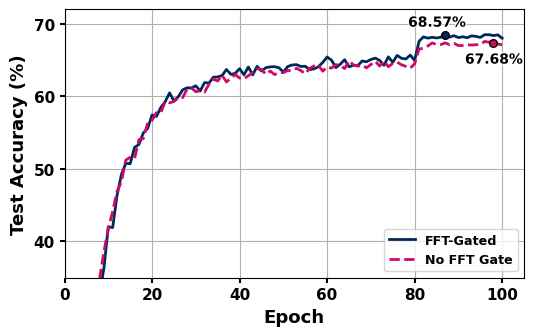

In [ ]:
########################################################################################################################
####-------| NOTE 13. FFT GATE VS NO_FFT GATE | XXX ------------------------------------------------####################
########################################################################################################################



import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patheffects as path_effects
import os

def read_test_log(file_path):
    test_loss_history = []
    test_acc_history = []
    with open(file_path, 'r') as f:
        for line in f:
            if "Test Loss" in line and "Test Acc" in line:
                try:
                    loss = float(line.split("Test Loss:")[1].split("|")[0].strip())
                    acc = float(line.split("Test Acc:")[1].split("%")[0].strip())
                    test_loss_history.append(loss)
                    test_acc_history.append(acc)
                except:
                    continue
    return test_loss_history, test_acc_history

def plot_train_test_metrics(save_dir="./Results/Plots"):
    os.makedirs(save_dir, exist_ok=True)

    FFT_test_log_path = f'./Results_FFTGated/CIFAR100_Test_B{bs}_LR{lr}_{net1}_{optimizer1}.txt'
    noFFT_test_log_path = f'./Results/CIFAR100_Test_{gate_mode}_B{bs}_LR{lr}_{net1}_{optimizer1}.txt'




    fft_test_loss, fft_test_acc = read_test_log(FFT_test_log_path)
    nofft_test_loss, nofft_test_acc = read_test_log(noFFT_test_log_path)

    num_epochs = min(len(fft_test_loss), len(nofft_test_loss))
    epochs = range(1, num_epochs + 1)

    COLOR_SCALE = ['#00295B', '#CF0A66']  # FFT, noFFT
    rcParams.update({
        "font.size": 11,
        "axes.titlesize": 11,
        "axes.labelsize": 13,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "axes.labelweight": "bold",
        "xtick.color": "black",
        "ytick.color": "black",
    })

    # Custom tick values and axis ranges
    custom_yticks_test_loss = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
    custom_yticks_test_Accu = [10, 20, 30, 40, 50, 60, 70]

    custom_xticks_test_loss = [0, 20, 40, 60, 80, 100]
    custom_xticks_test_Accu = [0, 20, 40, 60, 80, 100]

    custom_yaxis_test_loss = [1.2, 4.2]
    custom_yaxis_test_Accu = [35, 72]

    custom_xaxis_test_loss = [0, 105]
    custom_xaxis_test_Accu = [0, 105]

    # Annotation offsets
    y_offset_loss_fft = 0.2
    y_offset_loss_nofft = 0.07
    x_offset_loss_fft = 3.5
    x_offset_loss_nofft = 3.5

    y_offset_acc_fft = 1
    y_offset_acc_nofft = 3.2
    x_offset_acc_fft = 8.5
    x_offset_acc_nofft = 6.5

    # 🔷 Plot Loss
    fig1, ax1 = plt.subplots(figsize=(5.5, 3.5))
    ax1.plot(epochs, fft_test_loss[:num_epochs], label="Test Loss (FFT)", color=COLOR_SCALE[0], linewidth=2)
    ax1.plot(epochs, nofft_test_loss[:num_epochs], label="Test Loss (no_FFT)", color=COLOR_SCALE[1], linestyle='--', linewidth=2)
    ax1.set_xlabel("Epoch", fontweight='bold')
    ax1.set_ylabel("Loss", fontweight='bold')
    ax1.set_xticks(custom_xticks_test_loss)
    ax1.set_yticks(custom_yticks_test_loss)
    ax1.set_xlim(custom_xaxis_test_loss)
    ax1.set_ylim(custom_yaxis_test_loss)
    ax1.tick_params(axis='x', width=1.5)
    ax1.tick_params(axis='y', width=1.5)
    for label in ax1.get_xticklabels() + ax1.get_yticklabels():
        label.set_fontweight('bold')
    leg1 = ax1.legend(fontsize='small', loc="upper right")
    for text in leg1.get_texts():
        text.set_fontweight('bold')
    ax1.grid(True)

    ax1.plot(epochs[-1], fft_test_loss[-1], marker='o', color=COLOR_SCALE[0], markersize=4)
    ax1.text(epochs[-1] - x_offset_loss_fft, fft_test_loss[-1] - y_offset_loss_fft,
             f"{fft_test_loss[-1]:.2f}", fontsize=10, color='black', fontweight='bold',
             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()])
    ax1.plot(epochs[-1], nofft_test_loss[-1], marker='o', color=COLOR_SCALE[1], markersize=4)
    ax1.text(epochs[-1] - x_offset_loss_nofft, nofft_test_loss[-1] + y_offset_loss_nofft,
             f"{nofft_test_loss[-1]:.2f}", fontsize=10, color='black', fontweight='bold',
             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()])
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "compare_test_loss_fft_vs_nofft.svg"),
                format='svg', transparent=True, bbox_inches='tight')
    plt.close()

    # 🔶 Plot Accuracy — Marker at Best Accuracy
    best_epoch_fft = fft_test_acc.index(max(fft_test_acc)) + 1
    best_acc_fft = max(fft_test_acc)

    best_epoch_nofft = nofft_test_acc.index(max(nofft_test_acc)) + 1
    best_acc_nofft = max(nofft_test_acc)

    fig2, ax2 = plt.subplots(figsize=(5.5, 3.5))
    ax2.plot(epochs, fft_test_acc[:num_epochs], label="FFT-Gated", color=COLOR_SCALE[0], linewidth=2)
    ax2.plot(epochs, nofft_test_acc[:num_epochs], label="No FFT Gate", color=COLOR_SCALE[1], linestyle='--', linewidth=2)
    ax2.set_xlabel("Epoch", fontweight='bold')
    ax2.set_ylabel("Test Accuracy (%)", fontweight='bold')
    ax2.set_xticks(custom_xticks_test_Accu)
    ax2.set_yticks(custom_yticks_test_Accu)
    ax2.set_xlim(custom_xaxis_test_Accu)
    ax2.set_ylim(custom_yaxis_test_Accu)
    ax2.tick_params(axis='x', width=1.5)
    ax2.tick_params(axis='y', width=1.5)
    for label in ax2.get_xticklabels() + ax2.get_yticklabels():
        label.set_fontweight('bold')
    leg2 = ax2.legend(fontsize='small', loc="lower right")
    for text in leg2.get_texts():
        text.set_fontweight('bold')
    ax2.grid(True)

    # ax2.plot(best_epoch_fft, best_acc_fft, marker='o', color=COLOR_SCALE[0], markersize=4)
    ax2.plot(
    best_epoch_fft, best_acc_fft - 0.21,  # 💡Option A: Shift vertically (down a bit)
    marker='o',
    color=COLOR_SCALE[0],                    # fill color (pink)
    markersize=5.5,                          # size of marker
    markeredgecolor='black',                 # outline color
    markeredgewidth=1                        # thickness of outline
)    
    ax2.text(best_epoch_fft - x_offset_acc_fft, best_acc_fft + y_offset_acc_fft,
             f"{best_acc_fft:.2f}%", fontsize=10, color='black', fontweight='bold',
             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()]) 
    # ax2.plot(best_epoch_nofft, best_acc_nofft, marker='o', color=COLOR_SCALE[1], markersize=4)
    ax2.plot(
    best_epoch_nofft, best_acc_nofft - 0.4,  # 💡Option A: Shift vertically (down a bit)
    marker='o',
    color=COLOR_SCALE[1],                    # fill color (pink)
    markersize=5.5,                          # size of marker
    markeredgecolor='black',                 # outline color
    markeredgewidth=1                        # thickness of outline
)    
    ax2.text(best_epoch_nofft - x_offset_acc_nofft, best_acc_nofft - y_offset_acc_nofft,
             f"{best_acc_nofft:.2f}%", fontsize=10, color='black', fontweight='bold',
             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()])
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "compare_test_accuracy_fft_vs_nofft.svg"),
                format='svg', transparent=True, bbox_inches='tight')
    # plt.close()

    return f"✅ Annotated comparison plots with BEST accuracy markers saved to {save_dir}"





# 🔶🔹🔷 CALL PLOT FUNCTION

plot_train_test_metrics()